## Initial trial with pytorch, PEFT

In [ ]:
!nvidia-smi

Sat Jan 20 08:50:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorWithPadding, AutoProcessor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import peft
from peft import LoraConfig

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
!unzip -q '/content/gdrive/MyDrive/ERA1/capstone/instruct150K.zip' -d '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/instruct150k_detailed_captions.json" '/content'

In [ ]:
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

phi2_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
phi2_model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
print(f'len(tokenizer 1: {len(tokenizer)}')

tokenizer.pad_token = tokenizer.eos_token
bos_token_id = tokenizer.bos_token_id
pad_token_id = tokenizer.bos_token_id
eos_token_id = tokenizer.bos_token_id
eoi_string = 'caption image:'
eoi_tokens = tokenizer.encode(eoi_string)
print(f'eoi_tokens : {eoi_tokens}')
print(bos_token_id, pad_token_id, eos_token_id)
print(tokenizer.decode([50256, 50256, 50256]))
print('eoi tokens decoded:', tokenizer.decode(eoi_tokens))
print(len(tokenizer))

phi2_model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer 1: 50295
eoi_tokens : [6888, 1159, 2939, 25]
50256 50256 50256
<|endoftext|><|endoftext|><|endoftext|>
eoi tokens decoded: caption image:
50295


Embedding(50295, 2560)

In [ ]:
vision_model_name = 'openai/clip-vit-base-patch32' ## torch.Size([1, 49, 768])

clip_patches = 49
clip_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
clip_model = CLIPVisionModel.from_pretrained(vision_model_name).to(device)

In [ ]:
with open('/content/instruct150k_detailed_captions.json', 'r') as f:
    instruct150k_caption_data = json.load(f)

image_names_lst = []
excluded =0
for key, value in instruct150k_caption_data.items():
    if 'jpg_0' in key:
        image_names_lst.append(key)
    else:
        excluded += 1
print(f'len(image_names_lst) : {len(image_names_lst)}, excluded : {excluded} & len(instruct150k_caption_data) : {len(instruct150k_caption_data)}')

len(image_names_lst) : 81479, excluded : 326109 & len(instruct150k_caption_data) : 407588


In [ ]:
gt_len = 25
lt_len = 27

def tokenize_function_GT(caption):
    return tokenizer(caption, truncation=True)

instruct150k_caption_gt_data = {}
image_names_gt_lst = []
gt_count = 0
total = 0
for img in image_names_lst:
    total += 1
    caption = instruct150k_caption_data[img]
    tokenized_caption = tokenize_function_GT(caption)
    if len(tokenized_caption['input_ids']) > gt_len and len(tokenized_caption['input_ids']) < lt_len:
        instruct150k_caption_gt_data[img] = caption
        gt_count += 1
        image_names_gt_lst.append(img)
        # print(gt_20_count, len(tokenized_caption['input_ids']), img, caption)
print(len(instruct150k_caption_gt_data), gt_count, len(image_names_gt_lst), total)

40 40 40 81479


In [ ]:
class ClipEmbeddingDataset(Dataset):
    def __init__(self, image_names, caption_dict, tokenizer):
        self.data = image_names
        self.caption_dict = caption_dict
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx],
            'idx': idx
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        captions = [self.caption_dict[image_name] for image_name in image_names]
        tokenized_caption_samples = []
        for caption in captions:
            tokenized_caption_dict = self.tokenize_function(caption)
            tokenized_caption_samples.append(tokenized_caption_dict)
        collated_captions = self.data_collator(tokenized_caption_samples)
        caption_tokens = collated_captions['input_ids']
        caption_attn_mask = collated_captions['attention_mask']

        return {
            'image_names': image_names,
            'captions': captions,
            'caption_tokens': caption_tokens,
            'caption_attn_mask': caption_attn_mask
        }

In [ ]:
dataset = ClipEmbeddingDataset(image_names_gt_lst, instruct150k_caption_gt_data, tokenizer)

batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)
print(len(dataset))

40


In [ ]:
for idx, batch in enumerate(dataloader):
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    captions = batch['captions']  # List of captions corresponding to each data slice
    caption_tokens = batch['caption_tokens']  # Shape: [batch_size, max_seq_len]
    caption_attn_mask = batch['caption_attn_mask']
    print(idx)
    print(image_names)
    print(captions)
    print(caption_tokens.shape, caption_tokens)
    print(caption_attn_mask.shape)
    print('---------')
    if idx > 0:
        break

0
['000000388245.jpg_0', '000000456972.jpg_0']
['A cafeteria tray of three dishes: french fries, chickpeas with sauce-covered meat, and a noodle dish. ', "A red parrot eating food out of the palm of a hand of the person's arm on which the parrot is perched."]
torch.Size([2, 26]) tensor([[   32, 43075, 26473,   286,  1115, 16759,    25, 48718, 31757,    11,
         17943,   431,   292,   351, 10746,    12, 32111,  6174,    11,   290,
           257, 25099,   293,  9433,    13,   220],
        [   32,  2266,  1582, 10599,  6600,  2057,   503,   286,   262, 18057,
           286,   257,  1021,   286,   262,  1048,   338,  3211,   319,   543,
           262,  1582, 10599,   318, 49264,    13]])
torch.Size([2, 26])
---------
1
['000000540586.jpg_0', '000000146638.jpg_0']
['A living room is haphazardly decorated with furniture and a focal point consisting of a pet bed within a royal purple wall.', 'A laptop, a desktop computer, and various papers cover a large desk space with an empty chair

In [ ]:
class ClipProjectionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(channels)

        self.proj = nn.Sequential(
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

In [ ]:
class Phi2ProjModel(nn.Module):
    def __init__(self, clip_model, clip_processor, proj_model, phi2_model, clip_embed_dim=768, phi2_dim=2560):
        super(Phi2ProjModel, self).__init__()
        self.clip_embed_dim = clip_embed_dim
        self.phi2_dim = phi2_dim
        self.proj_lin_layer = nn.Linear(clip_embed_dim, phi2_dim)
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.proj_model = proj_model
        self.phi2_model = phi2_model

    def forward(self, x, target_tokens, target_len):
        inputs = self.clip_processor(images=x, return_tensors="pt").to(device)
        clip_output = self.clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
        clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
        image_embed = self.proj_lin_layer(clip_embeddings)   # B, 49, 2560
        image_embed = self.proj_model(image_embed)    # B, 49, 2560
        B, _, C = image_embed.shape
        eoi_tkn_tensor = torch.tensor(eoi_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
        eoi_tensor = eoi_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoi_embed = self.phi2_model.base_model.model.model.embed_tokens(eoi_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        # eoi_embed = self.phi2_model.model.embed_tokens(eoi_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        input_embed  = torch.cat([image_embed, eoi_embed], dim=1)  #B, 53, 2560 -> Adding EOI embeddings to indicate end of image
        input_embed = input_embed.to(dtype=torch.float16)
        print(f'input_embed.dtype : {input_embed.dtype}')
        # inputs_given = eoi_tensor[:, -1].unsqueeze(1)
        # print(f'inputs_given.shape at beg : {inputs_given.shape} input_embed.shape at beg : {input_embed.shape}')

        for i in range(target_len + 1):
            print(f'i : {i}')
            # if i > 0:
            #     inputs_given  = torch.cat([inputs_given, target_tkn], dim=1)

            output = self.phi2_model.forward(inputs_embeds = input_embed)

            next_word_logit = output.logits[:, -1, :].unsqueeze(1)  # B, 1, 50297

            if i < target_len:
                target_tkn = target_tokens[:, i].view(B, 1)  # B, 1
                target_tkn_embed = self.phi2_model.base_model.model.model.embed_tokens(target_tkn)  # B, 1, 2560 -> EOI embeddings (torch.float32)
                # target_tkn_embed = self.phi2_model.model.embed_tokens(target_tkn)  # B, 1, 2560 -> EOI embeddings (torch.float32)
                input_embed = torch.cat([input_embed, target_tkn_embed], dim=1)  #(B, 54, 2560), (B, 55, 2560)...(B, target_len+1, 2560)

            if i > 0:
                pred_logit = torch.cat([pred_logit, next_word_logit], dim=1) # (B, 2, 50297), (B, 3, 50297)...(B, target_len+1, 50297)
            else:
                pred_logit = next_word_logit # (B, 1, 50297)

        return pred_logit #, inputs_given

In [ ]:
for name, module in phi2_model.named_modules():
    print(name)

In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2",
    ]
)

In [ ]:
peft_phi2_model = peft.get_peft_model(phi2_model, peft_config)
peft_phi2_model.print_trainable_parameters()

trainable params: 94,371,840 || all params: 2,869,421,175 || trainable%: 3.2888807269640368


In [ ]:
projection_layer = ClipProjectionBlock(2560).to(device)

In [ ]:
phi2_proj_model = Phi2ProjModel(clip_model, clip_processor, projection_layer, peft_phi2_model).to(device)

In [ ]:
phi2_proj_model.phi2_model.base_model.model.model.embed_tokens

Embedding(50295, 2560)

In [ ]:
peft_phi2_model

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parms with grad : 591 & Parms w/o grad : 453


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, phi2_proj_model.parameters()), lr=1e-5, eps=1e-9)

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_ll_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_projm_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  15440 MiB |  15473 MiB | 259387 MiB | 243946 MiB |
|       from large pool |  12769 MiB |  12805 MiB | 228945 MiB | 216176 MiB |
|       from small pool |   2671 MiB |   2676 MiB |  30441 MiB |  27770 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  15440 MiB |  15473 MiB | 259387 MiB | 243946 MiB |
|       from large pool |  12769 MiB |  12805 MiB | 228945 MiB |

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomGELU(nn.Module):
    def forward(self, x):
        return F.gelu(x.clone())

class SimpleResBlock(nn.Module):
    def init(self, input_size):
        super().init()
        self.pre_norm = nn.LayerNorm(input_size)
        self.proj = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.GELU(),
            nn.Linear(input_size, input_size)
        )
    def forward(self, x):
        x = self.pre_norm()
        return x + self.proj(x).clone()

class Phi2wrapper(nn.Module):

    #This defines the structure of the NN.
    def init(self, input_dim_CLIP=768, input_dim_phi2=2560,
                 phi2_model=phi2_model_pretrained,
                tokenizer=tokenizer, teacher_forcing = 3, device=device):

        super(Phi2wrapper, self).init()

        self.input_dim_CLIP = input_dim_CLIP
        self.input_dim_phi2 = input_dim_phi2
        self.projection_img = nn.Linear(self.input_dim_CLIP, self.input_dim_phi2,
                                        bias=False)

        self.resblock = SimpleResBlock(self.input_dim_phi2)
        self.phi2_model = phi2_model
        self.tokenizer = tokenizer

        self.device = device
        self.teacher_forcing = teacher_forcing

        bos = self.tokenizer("Image: ", return_tensors="pt", return_attention_mask=False)
        eoi = self.tokenizer(" Question: ", return_tensors="pt", return_attention_mask=False)

        self.bos_embedding = self.phi2_model.get_input_embeddings()(bos.input_ids.to(self.device)).squeeze(0)
        self.eoi_embedding = self.phi2_model.get_input_embeddings()(eoi.input_ids.to(self.device)).squeeze(0)

        self.eos_embedding = self.phi2_model.get_input_embeddings()(torch.tensor(self.tokenizer.eos_token_id).to(self.device)).unsqueeze(0)

    def forward(self, x, input_q, target_a):

        x = self.projection_img(x)
        x = self.resblock(x)

        batch_size = x.shape[0]

        input_q_embedding = self.phi2_model.get_input_embeddings()(input_q)
        x = torch.cat((self.bos_embedding.repeat(batch_size,1,1), x,
                    self.eoi_embedding.repeat(batch_size,1,1), input_q_embedding), dim=1)

        loss = 0
        word_output_pred_tokens = None

#         print(self.phi2_model)
        # iterate over max_answer length
        for idx in range(target_a.shape[1]):
            print(x.dtype)

            out_phi = self.phi2_model.base_model.model.model.layers[0](x.clone().to(torch.float16))

            for layer_idx in range(1, 32):
                out_phi = self.phi2_model.base_model.model.model.layers[layer_idx](out_phi[0])

            out_phi = self.phi2_model.base_model.model.model.final_layernorm(out_phi[0])
            out_phi = self.phi2_model.base_model.model.lm_head(out_phi) ## torch.Size([batch, 55, 50297])

            next_word = torch.argmax(out_phi[:, -1, :], dim=-1) ## [batch]

            caption_word_token = target_a[:,idx]


            no_of_pad_tokens = sum(torch.eq(torch.tensor([self.tokenizer.pad_token_id]*batch_size).to(self.device),
                                            caption_word_token))

            if no_of_pad_tokens == torch.tensor(batch_size):
                break

            if idx>=self.teacher_forcing:
                caption_word_embedding = self.phi2_model.get_input_embeddings()(next_word).unsqueeze(1)
            else:
                caption_word_embedding = self.phi2_model.get_input_embeddings()(caption_word_token).unsqueeze(1)

            ## instead of append like instruct image output words.. instruct image w1 out, instruct image w2 output ..
            x = torch.cat((x.clone(), caption_word_embedding), dim=1)

            loss_val = F.cross_entropy(out_phi[:, -1, :], caption_word_token,
                        ignore_index=self.tokenizer.pad_token_id)

            loss += loss_val

            if word_output_pred_tokens is None:
                word_output_pred_tokens = next_word.unsqueeze(1)
            else:

                word_output_pred_tokens = torch.cat((word_output_pred_tokens, next_word.unsqueeze(1)), dim=1)

        loss_result = loss/idx

        return loss_result, word_output_pred_tokens


## Using instruct150k instructions and model.generate - seems weights are not changing

In [ ]:
!nvidia-smi

Tue Jan 23 06:43:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorWithPadding, AutoProcessor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import peft
from peft import LoraConfig

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
!unzip -q '/content/gdrive/MyDrive/ERA1/capstone/instruct150K.zip' -d '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/instruct150k_detailed_captions.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/complex_reasoning_77k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/conversation_58k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/detail_23k.json" '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json' '/content'

In [ ]:
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
print(f'len(tokenizer 1: {len(tokenizer)}')

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer 1: 50295


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
bos_token_id = tokenizer.bos_token_id
pad_token_id = tokenizer.bos_token_id
eos_token_id = tokenizer.bos_token_id
eoi_string = 'end of image:'
eoi_tokens = tokenizer.encode(eoi_string)
print(f'eoi_tokens : {eoi_tokens}')
eoi_tkn_tensor = torch.tensor(eoi_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
print(f'eoi_tkn_tensor.shape : {eoi_tkn_tensor.shape} - {eoi_tkn_tensor.get_device()}')
eoq_string = 'end of question:'
eoq_tokens = tokenizer.encode(eoq_string)
print(f'eoq_tokens : {eoq_tokens}')
eoq_tkn_tensor = torch.tensor(eoq_tokens, dtype=torch.int64).to(device)  # [4] -> EOQ token matrix
print(f'eoq_tkn_tensor.shape : {eoq_tkn_tensor.shape} - {eoq_tkn_tensor.get_device()}')
print(bos_token_id, pad_token_id, eos_token_id)
print(tokenizer.decode([50256, 50256, 50256]))
print('eoi tokens decoded:', tokenizer.decode(eoi_tokens))
print('eoq tokens decoded:', tokenizer.decode(eoq_tokens))
print(len(tokenizer))

eoi_tokens : [437, 286, 2939, 25]
eoi_tkn_tensor.shape : torch.Size([4]) - 0
eoq_tokens : [437, 286, 1808, 25]
eoq_tkn_tensor.shape : torch.Size([4]) - 0
50256 50256 50256
<|endoftext|><|endoftext|><|endoftext|>
eoi tokens decoded: end of image:
eoq tokens decoded: end of question:
50295


In [ ]:
with open('/content/instruct150k_detailed_captions.json', 'r') as f:
    instruct150k_caption_data = json.load(f)

image_names_lst = []
excluded =0
for key, value in instruct150k_caption_data.items():
    if 'jpg_0' in key:
        image_names_lst.append(key)
    else:
        excluded += 1
print(f'len(image_names_lst) : {len(image_names_lst)}')

len(image_names_lst) : 81479


#### Data preparation for stage-2

In [ ]:
with open('/content/complex_reasoning_77k.json', 'r') as f:
    complex_reasoning_data = json.load(f)

with open('/content/conversation_58k.json', 'r') as f:
    conversation_data = json.load(f)

with open('/content/detail_23k.json', 'r') as f:
    detail_data = json.load(f)

In [ ]:
len(complex_reasoning_data), len(conversation_data), len(detail_data)

(76643, 56681, 23240)

In [ ]:
complex_reasoning_data[0]

{'id': '000000215677',
 'image': '000000215677.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat skill set might someone need to perform such a frisbee trick?'},
  {'from': 'gpt',
   'value': 'To perform the frisbee trick shown in the image, where the man is passing a frisbee between or underneath his legs, a person would need a combination of skills. These skills include good hand-eye coordination, agility, balance, flexibility, and dexterity. Additionally, the ability to throw and catch the frisbee accurately while maintaining control of bodily movements would also be essential. To perfect the trick, practicing these skills and building up muscle memory through repetition would be beneficial.'}]}

In [ ]:
conversation_data[1000], len(conversation_data[1000]['conversations'])

({'id': '000000389673',
  'image': '000000389673.jpg',
  'conversations': [{'from': 'human',
    'value': '<image>\nWhat color is the cat in the image?'},
   {'from': 'gpt', 'value': 'The cat in the image is white.'},
   {'from': 'human', 'value': 'What is the cat doing in the image?'},
   {'from': 'gpt', 'value': 'The cat is sitting on top of a sofa in a room.'},
   {'from': 'human', 'value': 'What color is the sofa?'},
   {'from': 'gpt', 'value': 'The sofa is white.'},
   {'from': 'human', 'value': 'Are there any other items on the sofa?'},
   {'from': 'gpt', 'value': 'Yes, there are pillows on the sofa.'},
   {'from': 'human',
    'value': 'What factors should be considered to maintain a clean, white sofa, especially with a white cat sitting on it?'},
   {'from': 'gpt',
    'value': "Maintaining a clean, white sofa can be challenging, especially when there is a white cat sitting on it. Consider the following factors to keep the sofa clean and well-maintained:\n\n1. Regular cleaning:

In [ ]:
detail_data[10]

{'id': '000000076746',
 'image': '000000076746.jpg',
 'conversations': [{'from': 'human',
   'value': 'Write a detailed description of the given image.\n<image>'},
  {'from': 'gpt',
   'value': "The image shows a man in a black shirt and shorts standing on a tennis court, holding a tennis racket, and celebrating with a raised fist. A camera operator is nearby, recording the tennis player's actions, which might be for a competition or production.\n\nSeveral chairs are situated around the tennis court, with one closely placed behind the celebrating player and three others at the edges of the image. Additionally, there are four more individuals located around the court, one close to the camera operator and the others at different spots in the scene. They appear to be onlookers, possibly watching the event or supporting the tennis player."}]}

In [ ]:
# Checking one record per image
cd_set = set()
for rec in complex_reasoning_data:
    cd_set.add(rec['image'])

conv_set = set()
for rec in conversation_data:
    conv_set.add(rec['image'])


dtl_set = set()
for rec in detail_data:
    dtl_set.add(rec['image'])

print(len(cd_set), len(conv_set), len(dtl_set))
print(len(complex_reasoning_data), len(conversation_data), len(detail_data))
print(len(cd_set) + len(conv_set) + len(dtl_set))

# Checking total number of conversations
cd_conv_len = 0
for rec in complex_reasoning_data:
    cd_conv_len += len(rec['conversations'])

conv_conv_len = 0
for rec in conversation_data:
    conv_conv_len += len(rec['conversations'])

dtl_conv_len = 0
for rec in detail_data:
    dtl_conv_len += len(rec['conversations'])

print('Total conversations')
print(cd_conv_len, conv_conv_len, dtl_conv_len)
print(cd_conv_len+conv_conv_len+dtl_conv_len)

76643 56681 23240
76643 56681 23240
156564
Total conversations
153286 513740 46480
713506


In [ ]:
# Writing to conv_all_json
conv_all_json = []
for rec in complex_reasoning_data:
    conv_len = len(rec['conversations'])
    for i in range(0, conv_len, 2):
        conv_dict = {}
        conv_dict['image'] = rec['image']
        conv_dict['qn'] = rec['conversations'][i]['value']
        conv_dict['ans'] = rec['conversations'][i+1]['value']
        conv_dict['type'] = "complex"
        conv_all_json.append(conv_dict)
print(f'len(conv_all_json) after complex_reasoning_data: {len(conv_all_json)}')

for rec in conversation_data:
    conv_len = len(rec['conversations'])
    for i in range(0, conv_len, 2):
        conv_dict = {}
        conv_dict['image'] = rec['image']
        conv_dict['qn'] = rec['conversations'][i]['value']
        conv_dict['ans'] = rec['conversations'][i+1]['value']
        conv_dict['type'] = "conv"
        conv_all_json.append(conv_dict)
print(f'len(conv_all_json) after conversation_data: {len(conv_all_json)}')

for rec in detail_data:
    conv_len = len(rec['conversations'])
    for i in range(0, conv_len, 2):
        conv_dict = {}
        conv_dict['image'] = rec['image']
        conv_dict['type'] = "detail"
        conv_dict['qn'] = rec['conversations'][i]['value']
        conv_dict['ans'] = rec['conversations'][i+1]['value']
        conv_all_json.append(conv_dict)
print(f'len(conv_all_json) after detail_data: {len(conv_all_json)} == {(cd_conv_len+conv_conv_len+dtl_conv_len)/2}')

len(conv_all_json) after complex_reasoning_data: 76643
len(conv_all_json) after conversation_data: 333513
len(conv_all_json) after detail_data: 356753 == 356753.0


In [ ]:
## Checking conv_all_json sanity

for rec in conv_all_json:
    if rec['image'] == '000000389673.jpg':
        print(rec)

# Confirming 000000389673.jpg is indeed not there in detail_data
print('Confirming 000000389673.jpg is indeed not there in detail_data')
for rec in detail_data:
    if (rec['image'] == '000000389673.jpg' or rec['image'] == '000000442786.jpg' or rec['image'] == '000000076746.jpg'):
        print(rec)

{'image': '000000389673.jpg', 'qn': "<image>\nWhat difficulties might arise for the cat's owner in maintaining the cleanliness of the living space?", 'ans': "The cat's owner may face challenges in maintaining the cleanliness of the living space, particularly the white sofa. Since the white cat is sitting on top of the white sofa, it is likely that the cat's fur will shed onto the couch over time. This makes it harder to keep the couch clean and fresh-looking, as pet hair can accumulate and become more noticeable. The presence of fur on the white fabric may prompt the owner to frequently clean, vacuum or brush the sofa to remove pet hair and maintain its pristine appearance. Moreover, any dirt or stains from the cat's paws or body could also transfer to the sofa, further contributing to the challenge of keeping the room clean.", 'type': 'complex'}
{'image': '000000389673.jpg', 'qn': '<image>\nWhat color is the cat in the image?', 'ans': 'The cat in the image is white.', 'type': 'conv'}


In [ ]:
def tokenize_qna(text):
    return tokenizer(text, truncation=True)

In [ ]:
## Preparing tekenized json
conv_all_token_json = []
for idx, rec in enumerate(conv_all_json):
    conv_token_dict = rec
    qn_tokens = tokenize_qna(rec['qn'])['input_ids']
    ans_tokens = tokenize_qna(rec['ans'])['input_ids']
    conv_token_dict['qn_token'] = qn_tokens
    conv_token_dict['ans_token'] = ans_tokens
    lst = [len(ans_tokens), conv_token_dict]
    conv_all_token_json.append(lst)

In [ ]:
my_list = [[10, {"k1": "v1"}], [20, {"k2": "v2"}], [5, {"k3": "v3"}]]

# Sort the list based on the length of the sublists
sorted_list = sorted(my_list, key=lambda x: x[0])

print(sorted_list)

[[5, {'k3': 'v3'}], [10, {'k1': 'v1'}], [20, {'k2': 'v2'}]]


In [ ]:
# Sorting based on length of answer
sorted_conv_all_token_json = sorted(conv_all_token_json, key=lambda x: x[0])

In [ ]:
len(sorted_conv_all_token_json)

356753

In [ ]:
i = 0
for len_, item in sorted_conv_all_token_json:
    print(len_)
    i += 1
    print(len_, item)
    if i > 20:
        break

2
2 {'image': '000000257379.jpg', 'qn': '<image>\nHow many bears are in the image?', 'ans': 'There are', 'type': 'conv', 'qn_token': [27, 9060, 29, 198, 2437, 867, 13062, 389, 287, 262, 2939, 30], 'ans_token': [1858, 389]}
4
4 {'image': '000000127942.jpg', 'qn': "Based on the cows' behavior and surroundings, what can be said about their wellbeing?\n<image>", 'ans': 'In the image,', 'type': 'complex', 'qn_token': [15001, 319, 262, 22575, 6, 4069, 290, 21334, 11, 644, 460, 307, 531, 546, 511, 40013, 30, 198, 27, 9060, 29], 'ans_token': [818, 262, 2939, 11]}
4
4 {'image': '000000310108.jpg', 'qn': '<image>\nWhat are the possible reasons for freight trains being an essential part of modern transportation?', 'ans': 'Freight trains play', 'type': 'complex', 'qn_token': [27, 9060, 29, 198, 2061, 389, 262, 1744, 3840, 329, 30724, 13404, 852, 281, 6393, 636, 286, 3660, 9358, 30], 'ans_token': [20366, 432, 13404, 711]}
4
4 {'image': '000000155244.jpg', 'qn': 'What color is the bathtub?', 'ans': 

In [ ]:
for rec in conversation_data:
    if rec['image'] == '000000155244.jpg':
        print(rec)

{'id': '000000155244', 'image': '000000155244.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nIs there a bed in the same room as the bathtub?'}, {'from': 'gpt', 'value': 'Yes, there is a bed in the same room as the bathtub, on the other side of it. It appears that the bathtub opens up to the bedroom behind it, creating a combined bathroom and bedroom space.'}, {'from': 'human', 'value': 'What color is the bathtub?'}, {'from': 'gpt', 'value': 'The bathtub is'}]}


In [ ]:
with open('/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json', 'w') as file:
    json.dump(sorted_conv_all_token_json, file)

In [ ]:
!cp '/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json' '/content'

#### Training

In [ ]:
with open('/content/stage2_sorted_tokenized_instruct150k.json', 'r') as file:
    stage2_data = json.load(file)

In [ ]:
print(len(stage2_data))
stage2_data[1000]

356753


[6,
 {'image': '000000167494.jpg',
  'qn': 'What sport is the man playing?',
  'ans': 'The man is playing tennis.',
  'type': 'conv',
  'qn_token': [2061, 6332, 318, 262, 582, 2712, 30],
  'ans_token': [464, 582, 318, 2712, 20790, 13]}]

In [ ]:
class ClipEmbeddingDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx][-1]['image'],
            'idx': idx,
            'qn_text': self.data[idx][-1]['qn'],
            'ans_text': self.data[idx][-1]['ans']
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        qns = [item['qn_text'] for item in batch]
        ans = [item['ans_text'] for item in batch]
        tokenized_qns_lst = []
        for qn in qns:
            tokenized_qns_dict = self.tokenize_function(qn)
            tokenized_qns_lst.append(tokenized_qns_dict)
        collated_qns = self.data_collator(tokenized_qns_lst)

        tokenized_ans_lst = []
        for an in ans:
            tokenized_ans_dict = self.tokenize_function(an)
            tokenized_ans_lst.append(tokenized_ans_dict)
        collated_ans = self.data_collator(tokenized_ans_lst)
        qn_tokens = collated_qns['input_ids']
        an_tokens = collated_ans['input_ids']

        return {
            'image_names': image_names,
            'qn': qn_tokens,
            'ans': an_tokens
        }

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data, tokenizer)

batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

356753


In [ ]:
for idx, batch in enumerate(dataloader):
    print(batch.keys())
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    qn = batch['qn']  # List of captions corresponding to each data slice
    ans = batch['ans']  # Shape: [batch_size, max_seq_len]
    print(qn.shape)
    print(ans.shape)
    for i, q in enumerate(qn):
        print(i, tokenizer.decode(q))
    for i, a in enumerate(ans):
        print(i, tokenizer.decode(a))
    print('---------')
    if idx > 0:
        break

dict_keys(['image_names', 'qn', 'ans'])
torch.Size([10, 21])
torch.Size([10, 5])
0 <image>
How many bears are in the image?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
1 Based on the cows' behavior and surroundings, what can be said about their wellbeing?
<image>
2 <image>
What are the possible reasons for freight trains being an essential part of modern transportation?<|endoftext|>
3 What color is the bathtub?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
4 What type of animals are they?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
5 What color is the plate?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext

In [ ]:
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

phi2_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
phi2_model.config.use_cache = False

phi2_model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Embedding(50295, 2560)

In [ ]:
vision_model_name = 'openai/clip-vit-base-patch32' ## torch.Size([1, 49, 768])

clip_patches = 49
clip_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
clip_model = CLIPVisionModel.from_pretrained(vision_model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
class ClipProjectionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(channels)

        self.proj = nn.Sequential(
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

In [ ]:
class Phi2ProjModel(nn.Module):
    def __init__(self, clip_model, clip_processor, proj_model, phi2_model, clip_embed_dim=768, phi2_dim=2560):
        super(Phi2ProjModel, self).__init__()
        self.clip_embed_dim = clip_embed_dim
        self.phi2_dim = phi2_dim
        self.proj_lin_layer = nn.Linear(clip_embed_dim, phi2_dim)
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.proj_model = proj_model
        self.phi2_model = phi2_model

    def forward(self, x, qn_tokens, target_tokens, target_len):
        inputs = self.clip_processor(images=x, return_tensors="pt").to(device)
        clip_output = self.clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
        clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
        image_embed = self.proj_lin_layer(clip_embeddings)   # B, 49, 2560
        image_embed = self.proj_model(image_embed)    # B, 49, 2560
        B, _, C = image_embed.shape
        eoi_tensor = eoi_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoi_embed = self.phi2_model.base_model.model.model.embed_tokens(eoi_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        eoq_tensor = eoq_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoq_embed = self.phi2_model.base_model.model.model.embed_tokens(eoq_tensor)  # B, 4, 2560 -> EOQ embeddings (torch.float32)
        qn_embed = self.phi2_model.base_model.model.model.embed_tokens(qn_tokens)
        input_embed  = torch.cat([image_embed, eoi_embed, qn_embed, eoq_embed], dim=1)  #B, 49+4+Qn+4, 2560 -> Adding EOI embeddings to indicate end of image
        input_embed = input_embed.to(dtype=torch.float16)
        inputs_given = eoq_tensor[:, -1].unsqueeze(1)

        for i in range(target_len + 1):
            if i > 0:
                inputs_given  = torch.cat([inputs_given, target_tkn], dim=1)

            output = self.phi2_model.generate(inputs_embeds=input_embed,
                              max_new_tokens=1,
                              output_scores=True,
                              return_dict_in_generate = True,
                              bos_token_id=bos_token_id,
                              pad_token_id=bos_token_id,
                              eos_token_id=bos_token_id)

            next_word_logit = output.scores[0].unsqueeze(1) # B, 1, 50297

            if i < target_len:
                target_tkn = target_tokens[:, i].view(B, 1)  # B, 1
                target_tkn_embed = self.phi2_model.base_model.model.model.embed_tokens(target_tkn)  # B, 1, 2560 -> EOI embeddings (torch.float32)
                input_embed = torch.cat([input_embed, target_tkn_embed], dim=1)  #(B, 54, 2560), (B, 55, 2560)...(B, target_len+1, 2560)

            if i > 0:
                pred_logit = torch.cat([pred_logit, next_word_logit], dim=1) # (B, 2, 50297), (B, 3, 50297)...(B, target_len+1, 50297)
            else:
                pred_logit = next_word_logit # (B, 1, 50297)

        return pred_logit, inputs_given

In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2",
    ]
)

In [ ]:
peft_phi2_model = peft.get_peft_model(phi2_model, peft_config)
peft_phi2_model.print_trainable_parameters()

trainable params: 94,371,840 || all params: 2,869,421,175 || trainable%: 3.2888807269640368


In [ ]:
projection_layer = ClipProjectionBlock(2560).to(device)

In [ ]:
phi2_proj_model = Phi2ProjModel(clip_model, clip_processor, projection_layer, peft_phi2_model).to(device)

In [ ]:
other_grad_wt_count = 0
clip_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if "clip_model" in name:
        param.requires_grad = False
        clip_grad_wt_count += 1
    else:
        other_grad_wt_count += 1
print(f'Parms of clip made non-trainable : {clip_grad_wt_count} & Others untouched parms : {other_grad_wt_count}')

Parms of clip made non-trainable : 199 & Others untouched parms : 845


In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, phi2_proj_model.parameters()), lr=1e-5, eps=1e-9)

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_ll_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_projm_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
for idx, batch in enumerate(dataloader):

    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_ )  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    loss.requires_grad = True
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 10 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    # if idx % 75 == 0 and idx > 0:
    #     torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')

    if idx == 50:
        break

T_ : 5, A_: 21
idx: 0, loss: 4.963847637176514 tgt-len: 5
T_ : 5, A_: 8
idx: 1, loss: 4.498619079589844 tgt-len: 5
T_ : 5, A_: 7
idx: 2, loss: 3.997426748275757 tgt-len: 5
T_ : 5, A_: 9
idx: 3, loss: 4.480472087860107 tgt-len: 5
T_ : 5, A_: 8
idx: 4, loss: 3.9496870040893555 tgt-len: 5
T_ : 5, A_: 9
idx: 5, loss: 4.66316032409668 tgt-len: 5
T_ : 5, A_: 12
idx: 6, loss: 4.7451252937316895 tgt-len: 5
T_ : 5, A_: 12
idx: 7, loss: 4.877148151397705 tgt-len: 5
T_ : 5, A_: 11
idx: 8, loss: 4.814445972442627 tgt-len: 5
T_ : 5, A_: 8
idx: 9, loss: 3.694138526916504 tgt-len: 5
T_ : 5, A_: 10
idx: 10, loss: 4.556510925292969 tgt-len: 5
idx : 10
input: :The plate is white.
pred: Did plate the white.<|endoftext|>
GT: The plate is white.
T_ : 5, A_: 14
idx: 11, loss: 4.895440578460693 tgt-len: 5
T_ : 5, A_: 17
idx: 12, loss: 4.976585388183594 tgt-len: 5
T_ : 5, A_: 8
idx: 13, loss: 3.4757261276245117 tgt-len: 5
T_ : 5, A_: 16
idx: 14, loss: 4.924620628356934 tgt-len: 5
T_ : 5, A_: 8
idx: 15, loss: 

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        print(name)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

proj_lin_layer.weight
proj_lin_layer.bias
proj_model.pre_norm.weight
proj_model.pre_norm.bias
proj_model.proj.0.weight
proj_model.proj.0.bias
proj_model.proj.2.weight
proj_model.proj.2.bias
phi2_model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.dense.lora_A.default.weight
phi2_model.base_model.model.model.layers.0.self_attn.dense.lora_B.default.weight
phi2_model.base_model.model.model.layers.0.mlp.fc1.lora_A.default.weight
phi2_model.base_model.model.model.layers.0.mlp.fc1.lora_B.default.weight
phi2_model

## Using instruct150k instructions and model.forward with limited teacher forcing

In [ ]:
!nvidia-smi

Fri Jan 26 01:59:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196

In [ ]:
import os
import random
import json
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorWithPadding, AutoProcessor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import peft
from peft import LoraConfig

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
!unzip -q '/content/gdrive/MyDrive/ERA1/capstone/instruct150K.zip' -d '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/instruct150k_detailed_captions.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/complex_reasoning_77k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/conversation_58k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/detail_23k.json" '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json' '/content'

In [ ]:
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
print(f'len(tokenizer 1: {len(tokenizer)}')

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer 1: 50295


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
bos_token_id = tokenizer.bos_token_id
pad_token_id = tokenizer.bos_token_id
eos_token_id = tokenizer.bos_token_id
eoi_string = 'end of image:'
eoi_tokens = tokenizer.encode(eoi_string)
print(f'eoi_tokens : {eoi_tokens}')
eoi_tkn_tensor = torch.tensor(eoi_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
print(f'eoi_tkn_tensor.shape : {eoi_tkn_tensor.shape} - {eoi_tkn_tensor.get_device()}')
eoq_string = 'end of question:'
eoq_tokens = tokenizer.encode(eoq_string)
print(f'eoq_tokens : {eoq_tokens}')
eoq_tkn_tensor = torch.tensor(eoq_tokens, dtype=torch.int64).to(device)  # [4] -> EOQ token matrix
print(f'eoq_tkn_tensor.shape : {eoq_tkn_tensor.shape} - {eoq_tkn_tensor.get_device()}')
print(bos_token_id, pad_token_id, eos_token_id)
print(tokenizer.decode([50256, 50256, 50256]))
print('eoi tokens decoded:', tokenizer.decode(eoi_tokens))
print('eoq tokens decoded:', tokenizer.decode(eoq_tokens))
print(len(tokenizer))

eoi_tokens : [437, 286, 2939, 25]
eoi_tkn_tensor.shape : torch.Size([4]) - 0
eoq_tokens : [437, 286, 1808, 25]
eoq_tkn_tensor.shape : torch.Size([4]) - 0
50256 50256 50256
<|endoftext|><|endoftext|><|endoftext|>
eoi tokens decoded: end of image:
eoq tokens decoded: end of question:
50295


In [ ]:
with open('/content/stage2_sorted_tokenized_instruct150k.json', 'r') as file:
    stage2_data = json.load(file)

##### Checking stage_2_data

In [ ]:
stage2_data[0]

[2,
 {'image': '000000257379.jpg',
  'qn': '<image>\nHow many bears are in the image?',
  'ans': 'There are',
  'type': 'conv',
  'qn_token': [27, 9060, 29, 198, 2437, 867, 13062, 389, 287, 262, 2939, 30],
  'ans_token': [1858, 389]}]

In [ ]:
prev_len = 0
for idx, data in enumerate(stage2_data):
    ans_len = data[0]
    if prev_len != ans_len:
        print(f'idx : {idx}, ans_len : {ans_len}')
    prev_len = ans_len

idx : 0, ans_len : 2
idx : 1, ans_len : 4
idx : 5, ans_len : 5
idx : 592, ans_len : 6
idx : 1471, ans_len : 7
idx : 4069, ans_len : 8
idx : 13971, ans_len : 9
idx : 23390, ans_len : 10
idx : 34485, ans_len : 11
idx : 45557, ans_len : 12
idx : 55512, ans_len : 13
idx : 64744, ans_len : 14
idx : 73674, ans_len : 15
idx : 82199, ans_len : 16
idx : 90588, ans_len : 17
idx : 98766, ans_len : 18
idx : 106809, ans_len : 19
idx : 114645, ans_len : 20
idx : 122447, ans_len : 21
idx : 129819, ans_len : 22
idx : 136818, ans_len : 23
idx : 143379, ans_len : 24
idx : 149333, ans_len : 25
idx : 155036, ans_len : 26
idx : 160109, ans_len : 27
idx : 164730, ans_len : 28
idx : 168801, ans_len : 29
idx : 172546, ans_len : 30
idx : 175846, ans_len : 31
idx : 178811, ans_len : 32
idx : 181542, ans_len : 33
idx : 183906, ans_len : 34
idx : 186121, ans_len : 35
idx : 188104, ans_len : 36
idx : 189906, ans_len : 37
idx : 191586, ans_len : 38
idx : 193167, ans_len : 39
idx : 194550, ans_len : 40
idx : 195831,

##### Dataset class

In [ ]:
class ClipEmbeddingDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx][-1]['image'],
            'idx': idx,
            'qn_text': self.data[idx][-1]['qn'],
            'ans_text': self.data[idx][-1]['ans']
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        qns = [item['qn_text'] for item in batch]
        ans = [item['ans_text'] for item in batch]
        tokenized_qns_lst = []
        for qn in qns:
            tokenized_qns_dict = self.tokenize_function(qn)
            tokenized_qns_lst.append(tokenized_qns_dict)
        collated_qns = self.data_collator(tokenized_qns_lst)

        tokenized_ans_lst = []
        for an in ans:
            tokenized_ans_dict = self.tokenize_function(an)
            tokenized_ans_lst.append(tokenized_ans_dict)
        collated_ans = self.data_collator(tokenized_ans_lst)
        qn_tokens = collated_qns['input_ids']
        an_tokens = collated_ans['input_ids']

        return {
            'image_names': image_names,
            'qn': qn_tokens,
            'ans': an_tokens
        }

#### Training first 600 records

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

356753


In [ ]:
for idx, batch in enumerate(dataloader):
    print(batch.keys())
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    qn = batch['qn']  # List of captions corresponding to each data slice
    ans = batch['ans']  # Shape: [batch_size, max_seq_len]
    print(qn.shape)
    print(ans.shape)
    for i, q in enumerate(qn):
        print(i, tokenizer.decode(q))
    for i, a in enumerate(ans):
        print(i, tokenizer.decode(a))
    print('---------')
    if idx > 0:
        break

dict_keys(['image_names', 'qn', 'ans'])
torch.Size([1, 12])
torch.Size([1, 2])
0 <image>
How many bears are in the image?
0 There are
---------
dict_keys(['image_names', 'qn', 'ans'])
torch.Size([1, 21])
torch.Size([1, 4])
0 Based on the cows' behavior and surroundings, what can be said about their wellbeing?
<image>
0 In the image,
---------


In [ ]:
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

phi2_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
phi2_model.config.use_cache = False

phi2_model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Embedding(50295, 2560)

In [ ]:
vision_model_name = 'openai/clip-vit-base-patch32' ## torch.Size([1, 49, 768])

clip_patches = 49
clip_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
clip_model = CLIPVisionModel.from_pretrained(vision_model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
class ClipProjectionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(channels)

        self.proj = nn.Sequential(
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

In [ ]:
class Phi2ProjModel(nn.Module):
    def __init__(self, clip_model, clip_processor, proj_model, phi2_model, clip_embed_dim=768, phi2_dim=2560):
        super(Phi2ProjModel, self).__init__()
        self.clip_embed_dim = clip_embed_dim
        self.phi2_dim = phi2_dim
        self.proj_lin_layer = nn.Linear(clip_embed_dim, phi2_dim)
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.proj_model = proj_model
        self.phi2_model = phi2_model

    def forward(self, x, qn_tokens, target_tokens, target_len, teacher_force_pct):
        inputs = self.clip_processor(images=x, return_tensors="pt").to(device)
        clip_output = self.clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
        clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
        image_embed = self.proj_lin_layer(clip_embeddings)   # B, 49, 2560
        image_embed = self.proj_model(image_embed)    # B, 49, 2560
        B, _, C = image_embed.shape
        eoi_tensor = eoi_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoi_embed = self.phi2_model.base_model.model.model.embed_tokens(eoi_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        eoq_tensor = eoq_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoq_embed = self.phi2_model.base_model.model.model.embed_tokens(eoq_tensor)  # B, 4, 2560 -> EOQ embeddings (torch.float32)
        qn_embed = self.phi2_model.base_model.model.model.embed_tokens(qn_tokens)
        input_embed  = torch.cat([image_embed, eoi_embed, qn_embed, eoq_embed], dim=1)  #B, 49+4+Qn+4, 2560 -> Adding EOI embeddings to indicate end of image
        input_embed = input_embed.to(dtype=torch.float16)
        inputs_given = eoq_tensor[:, -1].unsqueeze(1)
        if teacher_force_pct > 0:
            num_teacher_force_tokens = int(target_len*teacher_force_pct/100)

        for i in range(target_len + 1):
            if i > 0:
                inputs_given  = torch.cat([inputs_given, target_tkn], dim=1)
                inputs_given_detached  = inputs_given.detach()

            # output = self.phi2_model.generate(inputs_embeds=input_embed,
            #                   max_new_tokens=1,
            #                   output_scores=True,
            #                   return_dict_in_generate = True,
            #                   bos_token_id=bos_token_id,
            #                   pad_token_id=bos_token_id,
            #                   eos_token_id=bos_token_id)
            output = self.phi2_model.forward(inputs_embeds = input_embed)
            # input_embed = input_embed.detach()

            # next_word_logit = output.scores[0].unsqueeze(1) # B, 1, 50297
            next_word_logit = output.logits[:, -1, :].unsqueeze(1)  # B, 1, 50297

            if i > 0:
                pred_logit = torch.cat([pred_logit, next_word_logit], dim=1) # (B, 2, 50297), (B, 3, 50297)...(B, target_len+1, 50297)
            else:
                pred_logit = next_word_logit # (B, 1, 50297)

            if i < target_len:
                if i < num_teacher_force_tokens:
                    target_tkn = target_tokens[:, i].view(B, 1)  # B, 1
                else:
                    B_, T_, C_ = next_word_logit.shape  # (B, 1, 50297)
                    next_word_logit = next_word_logit.reshape(B_*T_, C_)  # B*1, 50297
                    preds = F.softmax(next_word_logit, dim=-1) # B*1, 50297
                    target_tkn = torch.multinomial(preds, num_samples=1) # B*1, 1
                concat_embed = self.phi2_model.base_model.model.model.embed_tokens(target_tkn) # B, 1, 2560

                input_embed = torch.cat([input_embed, concat_embed], dim=1)  #(B, 54, 2560), (B, 55, 2560)...(B, target_len+1, 2560)

            # pred_logit = pred_logit.detach()

        return pred_logit, inputs_given

In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2",
    ]
)

In [ ]:
peft_phi2_model = peft.get_peft_model(phi2_model, peft_config)
peft_phi2_model.print_trainable_parameters()

trainable params: 94,371,840 || all params: 2,869,421,175 || trainable%: 3.2888807269640368


In [ ]:
projection_layer = ClipProjectionBlock(2560).to(device)

In [ ]:
phi2_proj_model = Phi2ProjModel(clip_model, clip_processor, projection_layer, peft_phi2_model).to(device)

In [ ]:
other_grad_wt_count = 0
clip_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if "clip_model" in name:
        param.requires_grad = False
        clip_grad_wt_count += 1
    else:
        other_grad_wt_count += 1
print(f'Parms of clip made non-trainable : {clip_grad_wt_count} & Others untouched parms : {other_grad_wt_count}')

Parms of clip made non-trainable : 199 & Others untouched parms : 845


In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, phi2_proj_model.parameters()), lr=1e-5, eps=1e-9)

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_ll_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phiproj_projm_jan19_1800pm.pth'))

<All keys matched successfully>

In [ ]:
tf_pct = 25  # Teacher forcing percent

for idx, batch in enumerate(dataloader):

    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')
        print(f'***phi2_proj_model saved at idx : {idx}')

    # if idx == 50:
    #     break

idx: 0, loss: 3.024033308029175 tgt-len: 2 num_tf_tokens: 0
idx: 1, loss: 4.09842586517334 tgt-len: 4 num_tf_tokens: 1
idx: 2, loss: 3.8333022594451904 tgt-len: 4 num_tf_tokens: 1
idx: 3, loss: 7.046946048736572 tgt-len: 4 num_tf_tokens: 1
idx: 4, loss: 1.5230953693389893 tgt-len: 4 num_tf_tokens: 1
idx: 5, loss: 3.5789644718170166 tgt-len: 5 num_tf_tokens: 1
idx: 6, loss: 3.262601852416992 tgt-len: 5 num_tf_tokens: 1
idx: 7, loss: 2.074625253677368 tgt-len: 5 num_tf_tokens: 1
idx: 8, loss: 5.42280387878418 tgt-len: 5 num_tf_tokens: 1
idx: 9, loss: 1.2429643869400024 tgt-len: 5 num_tf_tokens: 1
idx: 10, loss: 1.0469690561294556 tgt-len: 5 num_tf_tokens: 1
idx: 11, loss: 3.58454966545105 tgt-len: 5 num_tf_tokens: 1
idx: 12, loss: 4.054717540740967 tgt-len: 5 num_tf_tokens: 1
idx: 13, loss: 5.4073920249938965 tgt-len: 5 num_tf_tokens: 1
idx: 14, loss: 4.141565799713135 tgt-len: 5 num_tf_tokens: 1
idx: 15, loss: 0.9334402084350586 tgt-len: 5 num_tf_tokens: 1
idx: 16, loss: 3.5404281616210

KeyboardInterrupt: 

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[-5.9643e-04, -4.2410e-04,  4.9465e-04,  ...,  7.9674e-04,
         -4.5698e-04,  5.9060e-04],
        [-2.3780e-04, -1.4697e-04,  2.5806e-04,  ...,  5.5986e-04,
         -3.0714e-04,  4.5946e-04],
        [ 7.1572e-05,  1.1923e-04,  1.0510e-04,  ...,  1.3456e-04,
          2.7424e-05, -1.4871e-05],
        ...,
        [-3.6857e-04, -4.5292e-04,  2.9075e-05,  ..., -2.3679e-04,
         -3.2660e-04,  1.0757e-04],
        [-7.9448e-04, -8.4410e-04,  7.2796e-04,  ...,  8.2267e-04,
         -8.1550e-04,  7.3646e-04],
        [ 7.3211e-04,  6.2193e-04, -5.3399e-04,  ..., -6.5742e-04,
          7.1751e-04, -8.2005e-04]], device='cuda:0', requires_grad=True)
Parms with grad : 392 & Parms w/o grad : 652


#### Training resumes from 601th record

In [ ]:
stage2_data[601]

[6,
 {'image': '000000386919.jpg',
  'qn': 'How many stories does the building have?',
  'ans': 'The building has six stories.',
  'type': 'conv',
  'qn_token': [2437, 867, 3923, 857, 262, 2615, 423, 30],
  'ans_token': [464, 2615, 468, 2237, 3923, 13]}]

In [ ]:
stage2_data_v1 = stage2_data[601:]
len(stage2_data_v1), (len(stage2_data)-601), len(stage2_data)

(356152, 356152, 356753)

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data_v1, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

356152


In [ ]:
phi2_proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[-5.9026e-04, -4.2117e-04,  4.8287e-04,  ...,  7.9031e-04,
         -4.5153e-04,  5.7634e-04],
        [-2.1634e-04, -1.2404e-04,  2.3429e-04,  ...,  5.3218e-04,
         -2.8517e-04,  4.3852e-04],
        [ 7.6257e-05,  1.2588e-04,  1.0220e-04,  ...,  1.2702e-04,
          3.1189e-05, -1.8817e-05],
        ...,
        [-3.4245e-04, -4.2922e-04,  4.3237e-06,  ..., -2.6703e-04,
         -2.9926e-04,  8.0891e-05],
        [-8.3432e-04, -8.8152e-04,  7.6944e-04,  ...,  8.6295e-04,
         -8.5511e-04,  7.7836e-04],
        [ 6.6962e-04,  5.6040e-04, -4.6674e-04,  ..., -5.9406e-04,
          6.5090e-04, -7.5152e-04]], device='cuda:0', requires_grad=True)
Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
tf_pct = 25  # Teacher forcing percent
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')
        print(f'***phi2_proj_model saved at idx : {idx}')


idx: 0, loss: 0.5094996690750122 tgt-len: 6 num_tf_tokens: 1
idx: 1, loss: 0.3264548182487488 tgt-len: 6 num_tf_tokens: 1
idx: 2, loss: 0.12392459809780121 tgt-len: 6 num_tf_tokens: 1
idx: 3, loss: 0.23776772618293762 tgt-len: 6 num_tf_tokens: 1
idx: 4, loss: 2.527935028076172 tgt-len: 6 num_tf_tokens: 1
idx: 5, loss: 0.34070494771003723 tgt-len: 6 num_tf_tokens: 1
idx: 6, loss: 2.3287675380706787 tgt-len: 6 num_tf_tokens: 1
idx: 7, loss: 0.1676444560289383 tgt-len: 6 num_tf_tokens: 1
idx: 8, loss: 1.526718020439148 tgt-len: 6 num_tf_tokens: 1
idx: 9, loss: 2.686182737350464 tgt-len: 6 num_tf_tokens: 1
idx: 10, loss: 0.7620570063591003 tgt-len: 6 num_tf_tokens: 1
idx: 11, loss: 2.4362313747406006 tgt-len: 6 num_tf_tokens: 1
idx: 12, loss: 0.6199951171875 tgt-len: 6 num_tf_tokens: 1
idx: 13, loss: 0.09026873856782913 tgt-len: 6 num_tf_tokens: 1
idx: 14, loss: 0.06857055425643921 tgt-len: 6 num_tf_tokens: 1
idx: 15, loss: 2.909965753555298 tgt-len: 6 num_tf_tokens: 1
idx: 16, loss: 1.211

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 45163 has 14.74 GiB memory in use. Of the allocated memory 13.69 GiB is allocated by PyTorch, and 933.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Starting from 801st token

In [ ]:
stage2_data_v2 = stage2_data[801:]
len(stage2_data_v2), (len(stage2_data)-801), len(stage2_data)

(355952, 355952, 356753)

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data_v2, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

355952


In [ ]:
phi2_proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[-6.1965e-04, -4.1802e-04,  4.9744e-04,  ...,  8.3887e-04,
         -4.6198e-04,  6.3890e-04],
        [-4.3002e-04, -3.8297e-04,  4.6774e-04,  ...,  7.7001e-04,
         -5.1130e-04,  6.2559e-04],
        [-3.7554e-05,  5.3650e-05,  1.8992e-04,  ...,  2.5302e-04,
         -6.8607e-05,  1.3573e-04],
        ...,
        [-6.3760e-04, -6.9733e-04,  2.8906e-04,  ...,  7.0597e-06,
         -5.7879e-04,  3.4716e-04],
        [-9.1563e-04, -9.5887e-04,  8.4755e-04,  ...,  9.4071e-04,
         -9.2100e-04,  8.6141e-04],
        [ 9.1493e-04,  7.7625e-04, -6.8940e-04,  ..., -8.2698e-04,
          8.9387e-04, -1.0276e-03]], device='cuda:0', requires_grad=True)
Parms with grad : 591 & Parms w/o grad : 453


In [ ]:
tf_pct = 25  # Teacher forcing percent
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    A_ = qn_tokens.shape[-1]
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} qn-len: {A_} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')
        print(f'***phi2_proj_model saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 3332, loss: 0.8491376042366028 qn-len: 12 tgt-len: 8 num_tf_tokens: 2
idx: 3333, loss: 0.15399758517742157 qn-len: 11 tgt-len: 8 num_tf_tokens: 2
idx: 3334, loss: 0.1867900788784027 qn-len: 12 tgt-len: 8 num_tf_tokens: 2
idx: 3335, loss: 0.9146038889884949 qn-len: 13 tgt-len: 8 num_tf_tokens: 2
idx: 3336, loss: 3.5713016986846924 qn-len: 6 tgt-len: 8 num_tf_tokens: 2
idx: 3337, loss: 0.8464357852935791 qn-len: 13 tgt-len: 8 num_tf_tokens: 2
idx: 3338, loss: 0.5555987358093262 qn-len: 13 tgt-len: 8 num_tf_tokens: 2
idx: 3339, loss: 0.3218114376068115 qn-len: 10 tgt-len: 8 num_tf_tokens: 2
idx: 3340, loss: 0.3819786310195923 qn-len: 7 tgt-len: 8 num_tf_tokens: 2
idx: 3341, loss: 0.9261839389801025 qn-len: 14 tgt-len: 8 num_tf_tokens: 2
idx: 3342, loss: 0.1697114109992981 qn-len: 12 tgt-len: 8 num_tf_tokens: 2
idx: 3343, loss: 0.29259225726127625 qn-len: 9 tgt-len: 8 num_tf_tokens: 2
idx: 3344, loss: 0.3100699782371521 qn-len: 12 tgt

KeyboardInterrupt: 

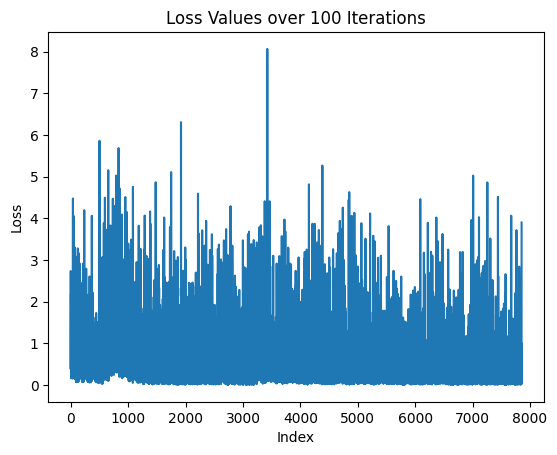

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 100 Iterations")

# Show the plot
plt.show()

#### Training resumes from 8601st record

In [ ]:
stage2_data_v3 = stage2_data[8601:]
len(stage2_data_v3), (len(stage2_data)-8601), len(stage2_data)

(348152, 348152, 356753)

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data_v3, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

348152


In [ ]:
phi2_proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
        elif name == "proj_model.proj.0.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[ 0.0004,  0.0017, -0.0078,  ..., -0.0215,  0.0169,  0.0007],
        [ 0.0154, -0.0002, -0.0041,  ...,  0.0159, -0.0026, -0.0183],
        [-0.0132,  0.0112,  0.0124,  ...,  0.0092,  0.0102, -0.0104],
        ...,
        [ 0.0122,  0.0206,  0.0126,  ..., -0.0178, -0.0045, -0.0098],
        [ 0.0202,  0.0131, -0.0118,  ...,  0.0112,  0.0029,  0.0116],
        [ 0.0212,  0.0028, -0.0053,  ..., -0.0109, -0.0003, -0.0148]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.7170e-03, -1.5113e-03,  2.1000e-03,  ...,  2.6837e-03,
         -2.4441e-03,  2.5407e-03],
        [ 4.8089e-05, -5.9032e-04,  4.4493e-05,  ...,  1.3950e-04,
         -2.9531e-04,  1.5985e-04],
        [-1.7380e-05,  5.3976e-04,  5.8668e-04,  ...,  6.4339e-04,
         -4.1055e-04,  4.1956e-04],
        ...,
        [ 3.1418e-04,  9.0146e-06, -1.3995e-03,  ..., -2.2082e-03,
          5.4330e-04, -1.0465e-03],
        [-8.4863e-04, -9.7706e-04,  1.2062e-03,  ...,

In [ ]:
tf_pct = 25  # Teacher forcing percent
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    A_ = qn_tokens.shape[-1]
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} qn-len: {A_} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')
        print(f'***phi2_proj_model saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 12883, loss: 0.326028972864151 qn-len: 13 tgt-len: 9 num_tf_tokens: 2
idx: 12884, loss: 0.3062867522239685 qn-len: 13 tgt-len: 9 num_tf_tokens: 2
idx: 12885, loss: 0.8843515515327454 qn-len: 10 tgt-len: 9 num_tf_tokens: 2
idx: 12886, loss: 0.48479071259498596 qn-len: 10 tgt-len: 9 num_tf_tokens: 2
idx: 12887, loss: 0.7995247840881348 qn-len: 10 tgt-len: 9 num_tf_tokens: 2
idx: 12888, loss: 0.7034078240394592 qn-len: 6 tgt-len: 9 num_tf_tokens: 2
idx: 12889, loss: 0.2927536368370056 qn-len: 9 tgt-len: 9 num_tf_tokens: 2
idx: 12890, loss: 0.465787798166275 qn-len: 10 tgt-len: 9 num_tf_tokens: 2
idx: 12891, loss: 0.15939810872077942 qn-len: 7 tgt-len: 9 num_tf_tokens: 2
idx: 12892, loss: 0.07510005682706833 qn-len: 14 tgt-len: 9 num_tf_tokens: 2
idx: 12893, loss: 0.5886868238449097 qn-len: 11 tgt-len: 9 num_tf_tokens: 2
idx: 12894, loss: 0.06403540074825287 qn-len: 13 tgt-len: 9 num_tf_tokens: 2
idx: 12895, loss: 0.22183313965797424 

KeyboardInterrupt: 

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
        elif name == "proj_model.proj.0.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[ 0.0011,  0.0025, -0.0067,  ..., -0.0217,  0.0166, -0.0003],
        [ 0.0160, -0.0013, -0.0036,  ...,  0.0150, -0.0032, -0.0185],
        [-0.0131,  0.0125,  0.0129,  ...,  0.0094,  0.0081, -0.0109],
        ...,
        [ 0.0129,  0.0217,  0.0137,  ..., -0.0188, -0.0054, -0.0105],
        [ 0.0212,  0.0134, -0.0109,  ...,  0.0105,  0.0018,  0.0102],
        [ 0.0211,  0.0042, -0.0046,  ..., -0.0105, -0.0011, -0.0152]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.8801e-03, -1.3244e-03,  2.7252e-03,  ...,  3.3120e-03,
         -2.8475e-03,  2.4736e-03],
        [ 1.3847e-03, -5.2212e-04, -1.4091e-03,  ..., -1.6903e-03,
          5.4608e-04, -1.2725e-03],
        [-1.7187e-03, -1.5031e-03,  2.8520e-03,  ...,  2.9281e-03,
         -1.8876e-03,  2.2761e-03],
        ...,
        [-1.0157e-04, -7.3007e-05, -1.8138e-03,  ..., -2.4496e-03,
          2.6612e-04, -8.5517e-04],
        [-1.0842e-03, -1.8429e-03,  2.4041e-03,  ...,

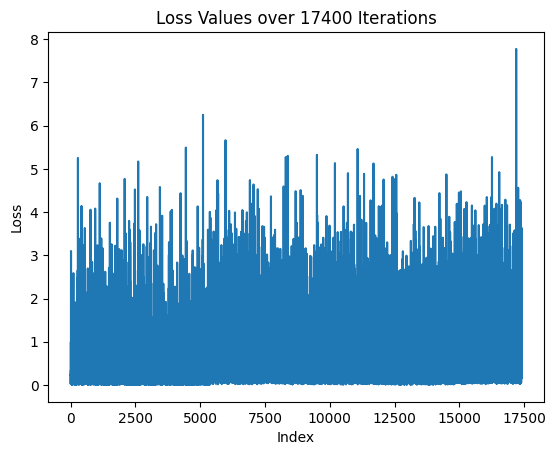

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 17400 Iterations")

# Show the plot
plt.show()

#### Training resuming from 17400 + 8600 = 26000

In [ ]:
stage2_data_v4 = stage2_data[26001:]
len(stage2_data_v4), (len(stage2_data)-26001), len(stage2_data)

(330752, 330752, 356753)

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data_v4, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

330752


In [ ]:
phi2_proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
        elif name == "proj_model.proj.0.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[ 0.0011,  0.0025, -0.0067,  ..., -0.0217,  0.0166, -0.0003],
        [ 0.0160, -0.0013, -0.0036,  ...,  0.0150, -0.0032, -0.0185],
        [-0.0131,  0.0125,  0.0129,  ...,  0.0094,  0.0081, -0.0109],
        ...,
        [ 0.0129,  0.0217,  0.0137,  ..., -0.0188, -0.0054, -0.0105],
        [ 0.0212,  0.0134, -0.0109,  ...,  0.0105,  0.0018,  0.0102],
        [ 0.0211,  0.0042, -0.0046,  ..., -0.0105, -0.0011, -0.0152]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.8820e-03, -1.3243e-03,  2.7237e-03,  ...,  3.3120e-03,
         -2.8454e-03,  2.4712e-03],
        [ 1.3817e-03, -5.2335e-04, -1.4098e-03,  ..., -1.6876e-03,
          5.4415e-04, -1.2705e-03],
        [-1.7153e-03, -1.4984e-03,  2.8462e-03,  ...,  2.9259e-03,
         -1.8836e-03,  2.2722e-03],
        ...,
        [-8.9738e-05, -6.2418e-05, -1.8261e-03,  ..., -2.4602e-03,
          2.7576e-04, -8.6494e-04],
        [-1.0811e-03, -1.8401e-03,  2.4023e-03,  ...,

In [ ]:
tf_pct = 25  # Teacher forcing percent
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    A_ = qn_tokens.shape[-1]
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} qn-len: {A_} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model.pth')
        print(f'***phi2_proj_model saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 7283, loss: 3.7422432899475098 qn-len: 10 tgt-len: 10 num_tf_tokens: 2
idx: 7284, loss: 0.11997876316308975 qn-len: 15 tgt-len: 10 num_tf_tokens: 2
idx: 7285, loss: 0.05703110620379448 qn-len: 12 tgt-len: 10 num_tf_tokens: 2
idx: 7286, loss: 0.49441060423851013 qn-len: 9 tgt-len: 10 num_tf_tokens: 2
idx: 7287, loss: 0.29939377307891846 qn-len: 10 tgt-len: 10 num_tf_tokens: 2
idx: 7288, loss: 0.20769669115543365 qn-len: 8 tgt-len: 10 num_tf_tokens: 2
idx: 7289, loss: 0.04770903289318085 qn-len: 14 tgt-len: 10 num_tf_tokens: 2
idx: 7290, loss: 0.49463146924972534 qn-len: 13 tgt-len: 10 num_tf_tokens: 2
idx: 7291, loss: 0.4539974331855774 qn-len: 8 tgt-len: 10 num_tf_tokens: 2
idx: 7292, loss: 0.26665937900543213 qn-len: 11 tgt-len: 10 num_tf_tokens: 2
idx: 7293, loss: 0.21213440597057343 qn-len: 15 tgt-len: 10 num_tf_tokens: 2
idx: 7294, loss: 0.533348023891449 qn-len: 9 tgt-len: 10 num_tf_tokens: 2
idx: 7295, loss: 0.41473099589347

KeyboardInterrupt: 

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "phi2_model.base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(param)
        elif name == "proj_model.proj.0.weight":
            print(param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parameter containing:
tensor([[ 0.0013,  0.0031, -0.0062,  ..., -0.0216,  0.0160, -0.0009],
        [ 0.0164, -0.0017, -0.0041,  ...,  0.0146, -0.0036, -0.0186],
        [-0.0136,  0.0138,  0.0127,  ...,  0.0100,  0.0069, -0.0104],
        ...,
        [ 0.0139,  0.0216,  0.0153,  ..., -0.0199, -0.0059, -0.0112],
        [ 0.0213,  0.0130, -0.0107,  ...,  0.0105,  0.0013,  0.0108],
        [ 0.0206,  0.0052, -0.0038,  ..., -0.0103, -0.0018, -0.0153]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-1.2176e-03, -2.6669e-04,  2.0916e-03,  ...,  2.9450e-03,
         -2.0245e-03,  1.7498e-03],
        [ 4.6833e-04, -1.5437e-03, -1.3683e-04,  ..., -2.7346e-04,
         -8.2711e-04,  4.7620e-04],
        [-2.2538e-03, -1.8827e-03,  3.4179e-03,  ...,  3.4753e-03,
         -2.3349e-03,  2.5650e-03],
        ...,
        [-3.8003e-05,  2.0945e-04, -2.0532e-03,  ..., -2.8213e-03,
          4.9996e-04, -1.0440e-03],
        [ 6.9564e-04, -6.2960e-05,  7.3299e-04,  ...,

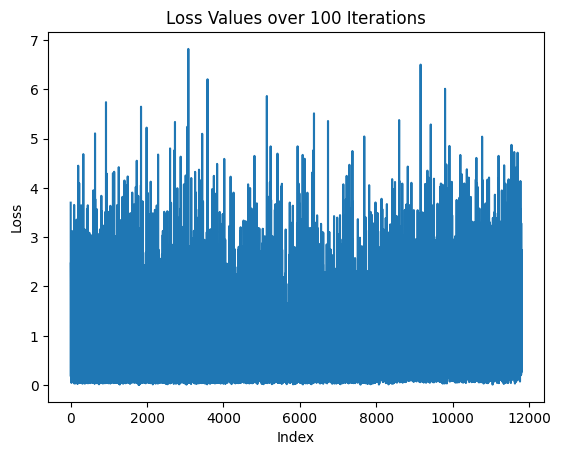

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 100 Iterations")

# Show the plot
plt.show()

#### Training resuming from 17400 + 8600 + 11800 = 37800. Also pushing to HF for merge

In [ ]:
stage2_data_v5 = stage2_data[37801:]
len(stage2_data_v5), (len(stage2_data)-37801), len(stage2_data)

(318952, 318952, 356753)

In [ ]:
dataset = ClipEmbeddingDataset(stage2_data_v5, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=False)
print(len(dataset))

318952


In [ ]:
for idx, batch in enumerate(dataloader):
    print(batch.keys())
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    qn = batch['qn']  # List of captions corresponding to each data slice
    ans = batch['ans']  # Shape: [batch_size, max_seq_len]
    print(qn.shape)
    print(ans.shape)
    for i, q in enumerate(qn):
        print(i, tokenizer.decode(q))
    for i, a in enumerate(ans):
        print(i, tokenizer.decode(a))
    print('---------')
    if idx > 0:
        break

dict_keys(['image_names', 'qn', 'ans'])
torch.Size([1, 11])
torch.Size([1, 11])
0 Where is the mirror positioned in relation to the desk?
0 The mirror is mounted on a wall above the desk.
---------
dict_keys(['image_names', 'qn', 'ans'])
torch.Size([1, 10])
torch.Size([1, 11])
0 What type of attire is the bicyclist wearing?
0 The bicyclist is wearing business-casual attire.
---------


In [ ]:
# phi2_proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_jan15_22pm_37800steps.pth'))

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_ll.pth'))
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_projmodel.pth'))
phi2_proj_model.phi2_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_phi2.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[-0.0044, -0.0133, -0.0006,  ...,  0.0072,  0.0137, -0.0007],
        [-0.0060, -0.0141, -0.0047,  ..., -0.0072,  0.0091,  0.0013],
        [-0.0180, -0.0045, -0.0111,  ...,  0.0164, -0.0187,  0.0044],
        ...,
        [ 0.0125, -0.0183, -0.0054,  ..., -0.0112,  0.0162,  0.0178],
        [ 0.0187, -0.0002, -0.0020,  ..., -0.0086,  0.0092,  0.0076],
        [-0.0074,  0.0114,  0.0269,  ...,  0.0186,  0.0076,  0.0114]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-1.3976e-03, -4.3075e-04,  2.2736e-03,  ...,  3.1257e-03,
         -2.2039e-03,  1.9346e-03],
        [ 6.2538e-04, -1.4381e-03, -2.0323e-04,  ..., -3.7605e-04,
         -6.7744e-04,  3.4052e-04],
        [-2.4928e-03, -1.9957e-03,  3.5574e-03,  ...,  3.6195e-03,
         -2.4835e-03,  2.7132e-03],
        ...,
        [-2.9304e-04, 

In [ ]:
tf_pct = 25  # Teacher forcing percent
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    A_ = qn_tokens.shape[-1]
    # print(f'T_ : {T_}, A_: {qn_tokens.shape[-1]}')
    #if T_ > 26:
    num_tf_tokens = int(T_* tf_pct/100)
    pred_logits, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, tot-idx: {idx+37800}, loss: {loss} qn-len: {A_} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    #else:
    #    print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')
        break

idx: 0, tot-idx: 37800, loss: 1.158554196357727 qn-len: 11 tgt-len: 11 num_tf_tokens: 2
idx: 1, tot-idx: 37801, loss: 2.6639297008514404 qn-len: 10 tgt-len: 11 num_tf_tokens: 2
idx: 2, tot-idx: 37802, loss: 1.2285826206207275 qn-len: 14 tgt-len: 11 num_tf_tokens: 2
idx: 3, tot-idx: 37803, loss: 2.032344102859497 qn-len: 13 tgt-len: 11 num_tf_tokens: 2
idx: 4, tot-idx: 37804, loss: 1.601336121559143 qn-len: 7 tgt-len: 11 num_tf_tokens: 2
idx: 5, tot-idx: 37805, loss: 0.35660743713378906 qn-len: 8 tgt-len: 11 num_tf_tokens: 2
idx: 6, tot-idx: 37806, loss: 0.8057012557983398 qn-len: 14 tgt-len: 11 num_tf_tokens: 2
idx: 7, tot-idx: 37807, loss: 0.14435826241970062 qn-len: 15 tgt-len: 11 num_tf_tokens: 2
idx: 8, tot-idx: 37808, loss: 0.4257887899875641 qn-len: 9 tgt-len: 11 num_tf_tokens: 2
idx: 9, tot-idx: 37809, loss: 1.420454978942871 qn-len: 10 tgt-len: 11 num_tf_tokens: 2
idx: 10, tot-idx: 37810, loss: 0.18102650344371796 qn-len: 13 tgt-len: 11 num_tf_tokens: 2
idx: 11, tot-idx: 37811,

In [ ]:
user = "anilbhatt1"  # put your user name here
model_name = "phi2-proj-peft-model"
model_id = f"{user}/{model_name}"

In [ ]:
peft_phi2_model.push_to_hub(model_id)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:141: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/893M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anilbhatt1/phi2-proj-peft-model/commit/f0589b90275e365b50f0bf299c65b256c79b1c38', commit_message='Upload model', commit_description='', oid='f0589b90275e365b50f0bf299c65b256c79b1c38', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[-0.0042, -0.0134, -0.0006,  ...,  0.0070,  0.0136, -0.0005],
        [-0.0060, -0.0141, -0.0047,  ..., -0.0073,  0.0093,  0.0014],
        [-0.0181, -0.0044, -0.0111,  ...,  0.0166, -0.0187,  0.0042],
        ...,
        [ 0.0125, -0.0184, -0.0053,  ..., -0.0111,  0.0161,  0.0176],
        [ 0.0187, -0.0001, -0.0020,  ..., -0.0085,  0.0092,  0.0074],
        [-0.0073,  0.0113,  0.0268,  ...,  0.0185,  0.0077,  0.0116]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-0.0015, -0.0005,  0.0024,  ...,  0.0032, -0.0023,  0.0021],
        [ 0.0007, -0.0014, -0.0002,  ..., -0.0004, -0.0006,  0.0003],
        [-0.0027, -0.0021,  0.0037,  ...,  0.0038, -0.0027,  0.0029],
        ...,
        [-0.0005, -0.0001, -0.0017,  ..., -0.0025,  0.0001, -0.0006],
        [ 0.0007, -0.0001,  0.0007,  ...,  0.0012, 

## Using instruct150k captions from stage-1 for training the adapters & see if any improvement - Improved

In [ ]:
!nvidia-smi

Fri Jan 26 14:49:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196

In [ ]:
import os
import random
import json
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorWithPadding, AutoProcessor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import peft
from peft import LoraConfig

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
!unzip -q '/content/gdrive/MyDrive/ERA1/capstone/instruct150K.zip' -d '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/instruct150k_detailed_captions.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/complex_reasoning_77k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/conversation_58k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/detail_23k.json" '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json' '/content'
!cp -r '/content/gdrive/MyDrive/ERA1/capstone/eval_data' '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_seen_images_v0.txt' '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_seen_images_v1.txt' '/content'

In [ ]:
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
print(f'len(tokenizer 1: {len(tokenizer)}')

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer 1: 50295


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
bos_token_id = tokenizer.bos_token_id
pad_token_id = tokenizer.bos_token_id
eos_token_id = tokenizer.bos_token_id

eoc_string = 'caption image:'
eoc_tokens = tokenizer.encode(eoc_string)
print(f'eoc_tokens : {eoc_tokens}')
eoc_tkn_tensor = torch.tensor(eoc_tokens, dtype=torch.int64).to(device)  # [4] -> EOC token matrix
print(f'eoc_tkn_tensor.shape : {eoc_tkn_tensor.shape} - {eoc_tkn_tensor.get_device()}')

eoi_string = 'end of image:'
eoi_tokens = tokenizer.encode(eoi_string)
print(f'eoi_tokens : {eoi_tokens}')
eoi_tkn_tensor = torch.tensor(eoi_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
print(f'eoi_tkn_tensor.shape : {eoi_tkn_tensor.shape} - {eoi_tkn_tensor.get_device()}')

eoq_string = 'end of question:'
eoq_tokens = tokenizer.encode(eoq_string)
print(f'eoq_tokens : {eoq_tokens}')
eoq_tkn_tensor = torch.tensor(eoq_tokens, dtype=torch.int64).to(device)  # [4] -> EOQ token matrix
print(f'eoq_tkn_tensor.shape : {eoq_tkn_tensor.shape} - {eoq_tkn_tensor.get_device()}')

print(bos_token_id, pad_token_id, eos_token_id)
print(tokenizer.decode([50256, 50256, 50256]))
print('eoc tokens decoded:', tokenizer.decode(eoc_tokens))
print('eoi tokens decoded:', tokenizer.decode(eoi_tokens))
print('eoq tokens decoded:', tokenizer.decode(eoq_tokens))
print(f'len(tokenizer 2: {len(tokenizer)}')

eoc_tokens : [6888, 1159, 2939, 25]
eoc_tkn_tensor.shape : torch.Size([4]) - 0
eoi_tokens : [437, 286, 2939, 25]
eoi_tkn_tensor.shape : torch.Size([4]) - 0
eoq_tokens : [437, 286, 1808, 25]
eoq_tkn_tensor.shape : torch.Size([4]) - 0
50256 50256 50256
<|endoftext|><|endoftext|><|endoftext|>
eoc tokens decoded: caption image:
eoi tokens decoded: end of image:
eoq tokens decoded: end of question:
len(tokenizer 2: 50295


In [ ]:
with open('/content/instruct150k_detailed_captions.json', 'r') as f:
    instruct150k_caption_data = json.load(f)

image_names_lst = []
excluded =0
for key, value in instruct150k_caption_data.items():
    if 'jpg_0' in key:
        image_names_lst.append(key)
    else:
        excluded += 1
print(f'len(image_names_lst) : {len(image_names_lst)}, excluded : {excluded} & len(instruct150k_caption_data) : {len(instruct150k_caption_data)}')

len(image_names_lst) : 81479, excluded : 326109 & len(instruct150k_caption_data) : 407588


In [ ]:
seen_images_lst = []

with open("/content/phi2_proj_model_seen_images_v0.txt", "r") as file1:
    seen_images_lst.extend(file1.readlines())

with open("/content/phi2_proj_model_seen_images_v1.txt", "r") as file2:
    seen_images_lst.extend(file2.readlines())

# Optionally remove newline characters if needed
seen_images_lst = [line.strip() for line in seen_images_lst]

print(len(seen_images_lst))

3806


In [ ]:
unseen_image_names_lst = []
for img_ in image_names_lst:
    nm = img_.split('_')[0]
    if nm in seen_images_lst:
        pass
    else:
        unseen_image_names_lst.append(img_)

print(len(seen_images_lst))
print(f'{len(unseen_image_names_lst)} == {len(image_names_lst) - len(seen_images_lst)}')

3806
77673 == 77673


In [ ]:
class ClipEmbeddingDataset(Dataset):
    def __init__(self, image_names, caption_dict, tokenizer):
        self.data = image_names
        self.caption_dict = caption_dict
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx],
            'idx': idx
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        captions = [self.caption_dict[image_name] for image_name in image_names]
        tokenized_caption_samples = []
        for caption in captions:
            tokenized_caption_dict = self.tokenize_function(caption)
            tokenized_caption_samples.append(tokenized_caption_dict)
        collated_captions = self.data_collator(tokenized_caption_samples)
        caption_tokens = collated_captions['input_ids']
        caption_attn_mask = collated_captions['attention_mask']

        return {
            'image_names': image_names,
            'captions': captions,
            'caption_tokens': caption_tokens,
            'caption_attn_mask': caption_attn_mask
        }

In [ ]:
# dataset = ClipEmbeddingDataset(image_names_lst, instruct150k_caption_data, tokenizer)
dataset = ClipEmbeddingDataset(unseen_image_names_lst, instruct150k_caption_data, tokenizer)

batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)
print(len(dataset))

77673


In [ ]:
for idx, batch in enumerate(dataloader):
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    captions = batch['captions']  # List of captions corresponding to each data slice
    caption_tokens = batch['caption_tokens']  # Shape: [batch_size, max_seq_len]
    caption_attn_mask = batch['caption_attn_mask']
    print(idx)
    print(image_names)
    print(captions)
    print(caption_tokens.shape, caption_tokens)
    print(caption_attn_mask.shape)
    print('---------')
    if idx > 0:
        break

0
['000000292537.jpg_0']
['The girl is eating fruit at the table']
torch.Size([1, 8]) tensor([[ 464, 2576,  318, 6600, 8234,  379,  262, 3084]])
torch.Size([1, 8])
---------
1
['000000549773.jpg_0']
['A green truck with a cow poking its head out']
torch.Size([1, 10]) tensor([[   32,  4077,  7779,   351,   257,  9875, 39048,   663,  1182,   503]])
torch.Size([1, 10])
---------


In [ ]:
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

phi2_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
phi2_model.config.use_cache = False

phi2_model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Embedding(50295, 2560)

In [ ]:
vision_model_name = 'openai/clip-vit-base-patch32' ## torch.Size([1, 49, 768])

clip_patches = 49
clip_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
clip_model = CLIPVisionModel.from_pretrained(vision_model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
class ClipProjectionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(channels)

        self.proj = nn.Sequential(
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

In [ ]:
class Phi2ProjModel(nn.Module):
    def __init__(self, clip_model, clip_processor, proj_model, phi2_model, clip_embed_dim=768, phi2_dim=2560):
        super(Phi2ProjModel, self).__init__()
        self.clip_embed_dim = clip_embed_dim
        self.phi2_dim = phi2_dim
        self.proj_lin_layer = nn.Linear(clip_embed_dim, phi2_dim)
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.proj_model = proj_model
        self.phi2_model = phi2_model

    def forward(self, x, target_tokens, target_len, teacher_force_pct):
        inputs = self.clip_processor(images=x, return_tensors="pt").to(device)
        clip_output = self.clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
        clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
        image_embed = self.proj_lin_layer(clip_embeddings)   # B, 49, 2560
        image_embed = self.proj_model(image_embed)    # B, 49, 2560
        B, _, C = image_embed.shape
        eoc_tensor = eoc_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoc_embed = self.phi2_model.base_model.model.model.embed_tokens(eoc_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        input_embed  = torch.cat([image_embed, eoc_embed], dim=1)  #B, 49+4+Qn+4, 2560 -> Adding EOI embeddings to indicate end of image
        input_embed = input_embed.to(dtype=torch.float16)
        inputs_given = eoc_tensor[:, -1].unsqueeze(1)
        if teacher_force_pct > 0:
            num_teacher_force_tokens = int(target_len*teacher_force_pct/100)

        for i in range(target_len + 1):
            if i > 0:
                inputs_given  = torch.cat([inputs_given, target_tkn], dim=1)
                inputs_given_detached  = inputs_given.detach()

            output = self.phi2_model.forward(inputs_embeds = input_embed)

            next_word_logit = output.logits[:, -1, :].unsqueeze(1)  # B, 1, 50297

            if i > 0:
                pred_logit = torch.cat([pred_logit, next_word_logit], dim=1) # (B, 2, 50297), (B, 3, 50297)...(B, target_len+1, 50297)
            else:
                pred_logit = next_word_logit # (B, 1, 50297)

            if i < target_len:
                target_tkn = target_tokens[:, i].view(B, 1)  # B, 1
                target_tkn_embed = self.phi2_model.base_model.model.model.embed_tokens(target_tkn)  # B, 1, 2560 -> EOI embeddings (torch.float32)
                input_embed = torch.cat([input_embed, target_tkn_embed], dim=1)  #(B, 54, 2560), (B, 55, 2560)...(B, target_len+1, 2560)

        return pred_logit, inputs_given

In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2",
    ]
)

In [ ]:
peft_phi2_model = peft.get_peft_model(phi2_model, peft_config)
peft_phi2_model.print_trainable_parameters()

trainable params: 94,371,840 || all params: 2,869,421,175 || trainable%: 3.2888807269640368


In [ ]:
projection_layer = ClipProjectionBlock(2560).to(device)

In [ ]:
phi2_proj_model = Phi2ProjModel(clip_model, clip_processor, projection_layer, peft_phi2_model).to(device)

In [ ]:
other_grad_wt_count = 0
clip_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if "clip_model" in name:
        param.requires_grad = False
        clip_grad_wt_count += 1
    else:
        other_grad_wt_count += 1
print(f'Parms of clip made non-trainable : {clip_grad_wt_count} & Other untouched parms : {other_grad_wt_count}')

Parms of clip made non-trainable : 199 & Other untouched parms : 845


In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, phi2_proj_model.parameters()), lr=1e-4, eps=1e-7)

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_ll.pth'))
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_projmodel.pth'))
phi2_proj_model.phi2_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_phi2.pth'))

<All keys matched successfully>

In [ ]:
eval_images = os.listdir('/content/eval_data')
print(eval_images, len(eval_images))
rand_idx = random.randint(0, len(eval_images)-1)
eval_img_name = eval_images[rand_idx]
print(rand_idx, eval_img_name)
# pil_image_caption = Image.open(f'/content/eval_data/{eval_img_name}')


['flower.jpg', 'imagenet_blackswan_100.jpeg', 'horse_emlo2_s4.jpeg', 'Hampi.jpg', 'cat1.jpg', 'jeep.jpeg', 'imagenet_meerkat_298.jpeg', 'imagenet_goldfish_001.jpeg', 'bird_emlo2_s4.jpeg', 'imagenet_tibetanterrier_200.jpeg'] 10
2 horse_emlo2_s4.jpeg


In [ ]:
def eval_caption_embed(img):
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    clip_output = clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
    clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
    image_embed = phi2_proj_model.proj_lin_layer(clip_embeddings)   # B, 49, 2560
    image_embed = phi2_proj_model.proj_model(image_embed)    # B, 49, 2560
    B, _, C = image_embed.shape
    eoc_tkn_tensor = torch.tensor(eoc_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
    eoc_tensor = eoc_tkn_tensor.repeat(B, 1)  # [B, 4]
    eoc_embed = phi2_proj_model.phi2_model.base_model.model.model.embed_tokens(eoc_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
    input_embed  = torch.cat([image_embed, eoc_embed], dim=1)  #B, 53, 2560 -> Adding EOI embeddings to indicate end of image
    input_embed = input_embed.to(dtype=torch.float16)
    output = phi2_proj_model.phi2_model.generate(inputs_embeds=input_embed,
                                                  bos_token_id=bos_token_id)

    output_txt = tokenizer.batch_decode(output)

    return output_txt

In [ ]:
def write_set_file(seen_images_set):
    with open("/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_seen_images.txt", "w") as file:
        i = 0
        for element in seen_images_set:
            file.write(f"{element}\n")
            i += 1
    return i

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[ 0.0158, -0.0129,  0.0110,  ..., -0.0081,  0.0011, -0.0114],
        [ 0.0162,  0.0109, -0.0120,  ...,  0.0050, -0.0089, -0.0147],
        [ 0.0095, -0.0127,  0.0115,  ...,  0.0088, -0.0007, -0.0067],
        ...,
        [-0.0100, -0.0110, -0.0138,  ...,  0.0060, -0.0174, -0.0156],
        [-0.0023,  0.0062,  0.0041,  ..., -0.0097,  0.0136, -0.0005],
        [-0.0045,  0.0072,  0.0087,  ...,  0.0169,  0.0109,  0.0165]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-1.0916e-04, -2.3178e-04,  2.4064e-05,  ...,  1.8155e-04,
          7.4021e-04,  8.8673e-05],
        [-9.8709e-04, -5.1715e-04,  1.2527e-03,  ...,  4.1670e-04,
         -2.9384e-04,  1.4175e-03],
        [ 4.3246e-04,  7.8166e-04,  2.8200e-04,  ..., -3.5371e-04,
          2.1097e-04, -4.0210e-04],
        ...,
        [ 7.6493e-04, 

##### Training 3400 images

In [ ]:
tf_pct = 100  # Teacher forcing percent
loss_lst = []
seen_images = set()

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    target_tokens = batch['caption_tokens'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    print(f'T_ : {T_}')
    if T_ < 17:
        num_tf_tokens = int(T_* tf_pct/100)
        pred_logits, inputs_given = phi2_proj_model(pil_img_lst, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

        B, T, C = pred_logits.shape  # (B, target_len, 50297)
        pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

        preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
        top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
        display_ids = top_prob.view(B, T)   # B, T

        eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
        targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
        # targets = targets[:, 1:]  # Offset by one position
        tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

        loss = F.cross_entropy(pred_logits, tgts)
        # loss.requires_grad = True
        loss.backward()
        loss_lst.append(round(loss.item(),4))
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        for name in batch['image_names']:
            seen_images.add(image_name)

        print(f'idx: {idx}, loss: {loss} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    else:
        print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {batch['captions'][0]}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')
        recs_written = write_set_file(seen_images)
        print(f'***Seen image names saved : {recs_written}')
        rand_idx = random.randint(0, len(eval_images)-1)
        eval_img_name = eval_images[rand_idx]
        print(f'***Starting eval with {eval_img_name} for rand_idx : {rand_idx}')
        pil_image_caption = Image.open(f'/content/eval_data/{eval_img_name}')
        with torch.no_grad():
            eval_text = eval_caption_embed(pil_image_caption)
        print(f'***eval_text : {eval_text}')

T_ : 19
idx: 0 Caption too long ! Hence skipping - img_name_b : 000000021782.jpg_0, T_: 19
T_ : 14
idx: 1, loss: 2.999178171157837 tgt-len: 14 num_tf_tokens: 14
T_ : 12
idx: 2, loss: 1.1332517862319946 tgt-len: 12 num_tf_tokens: 12
T_ : 10
idx: 3, loss: 2.8869426250457764 tgt-len: 10 num_tf_tokens: 10
T_ : 11
idx: 4, loss: 1.3935704231262207 tgt-len: 11 num_tf_tokens: 11
T_ : 15
idx: 5, loss: 1.7513160705566406 tgt-len: 15 num_tf_tokens: 15
T_ : 16
idx: 6, loss: 2.7955410480499268 tgt-len: 16 num_tf_tokens: 16
T_ : 15
idx: 7, loss: 4.5850396156311035 tgt-len: 15 num_tf_tokens: 15
T_ : 10
idx: 8, loss: 2.1553356647491455 tgt-len: 10 num_tf_tokens: 10
T_ : 13
idx: 9, loss: 1.8925892114639282 tgt-len: 13 num_tf_tokens: 13
T_ : 12
idx: 10, loss: 0.9995202422142029 tgt-len: 12 num_tf_tokens: 12
T_ : 15
idx: 11, loss: 2.7987253665924072 tgt-len: 15 num_tf_tokens: 15
T_ : 11
idx: 12, loss: 2.0265309810638428 tgt-len: 11 num_tf_tokens: 11
T_ : 10
idx: 13, loss: 1.9129582643508911 tgt-len: 10 n

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
T_ : 12
idx: 1100, loss: 2.4640276432037354 tgt-len: 12 num_tf_tokens: 12
idx : 1100
input: :A young boy under a red bedspread sleeps in bed.
pred: S lovely boy laying the blanket comspread. with bed.<|endoftext|>
tgt: A young boy under a red bedspread sleeps in bed.<|endoftext|>
GT: A young boy under a red bedspread sleeps in bed.
T_ : 13
idx: 1101, loss: 3.2832794189453125 tgt-len: 13 num_tf_tokens: 13
T_ : 9
idx: 1102, loss: 2.7066259384155273 tgt-len: 9 num_tf_tokens: 9
T_ : 10
idx: 1103, loss: 0.9117529392242432 tgt-len: 10 num_tf_tokens: 10
T_ : 10
idx: 1104, loss: 2.612354040145874 tgt-len: 10 num_tf_tokens: 10
T_ : 12
idx: 1105, loss: 2.672315835952759 tgt-len: 12 num_tf_tokens: 12
T_ : 13
idx: 1106, loss: 1.5505263805389404 tgt-len: 13 num_tf_tokens: 13
T_ : 11
idx: 1107, loss: 0.9099168181419373 tgt-len: 11 num_tf_tokens: 11
T_ : 11
idx: 1108, loss: 0.9117698073387146 tgt-len: 11 num_tf_tokens: 11
T_ : 13
idx: 1109, loss: 1.0

##### Training next 200 images

In [ ]:
tf_pct = 100  # Teacher forcing percent
loss_lst = []
seen_images = set()

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    target_tokens = batch['caption_tokens'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest caption in batch
    print(f'T_ : {T_}')
    if T_ < 17:
        num_tf_tokens = int(T_* tf_pct/100)
        pred_logits, inputs_given = phi2_proj_model(pil_img_lst, target_tokens, T_, tf_pct)  # (B, target_len, 50297)

        B, T, C = pred_logits.shape  # (B, target_len, 50297)
        pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

        preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
        top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
        display_ids = top_prob.view(B, T)   # B, T

        eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
        targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
        # targets = targets[:, 1:]  # Offset by one position
        tgts = targets.reshape(B * (T_+1)) # B*T_+1 -> Reshaping for loss fn

        loss = F.cross_entropy(pred_logits, tgts)
        # loss.requires_grad = True
        loss.backward()
        loss_lst.append(round(loss.item(),4))
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        for name in batch['image_names']:
            seen_images.add(image_name)

        print(f'idx: {idx}, loss: {loss} tgt-len: {T_} num_tf_tokens: {num_tf_tokens}')
    else:
        print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        input_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"input: {input_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT: {batch['captions'][0]}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')
        recs_written = write_set_file(seen_images)
        print(f'***Seen image names saved : {recs_written}')
        rand_idx = random.randint(0, len(eval_images)-1)
        eval_img_name = eval_images[rand_idx]
        print(f'***Starting eval with {eval_img_name} for rand_idx : {rand_idx}')
        pil_image_caption = Image.open(f'/content/eval_data/{eval_img_name}')
        with torch.no_grad():
            eval_text = eval_caption_embed(pil_image_caption)
        print(f'***eval_text : {eval_text}')

T_ : 10
idx: 0, loss: 1.3713041543960571 tgt-len: 10 num_tf_tokens: 10
T_ : 11
idx: 1, loss: 1.1255773305892944 tgt-len: 11 num_tf_tokens: 11
T_ : 13
idx: 2, loss: 2.117053747177124 tgt-len: 13 num_tf_tokens: 13
T_ : 10
idx: 3, loss: 4.645772933959961 tgt-len: 10 num_tf_tokens: 10
T_ : 10
idx: 4, loss: 2.301135540008545 tgt-len: 10 num_tf_tokens: 10
T_ : 12
idx: 5, loss: 3.0097546577453613 tgt-len: 12 num_tf_tokens: 12
T_ : 13
idx: 6, loss: 1.489633321762085 tgt-len: 13 num_tf_tokens: 13
T_ : 10
idx: 7, loss: 2.779400110244751 tgt-len: 10 num_tf_tokens: 10
T_ : 12
idx: 8, loss: 3.3165817260742188 tgt-len: 12 num_tf_tokens: 12
T_ : 14
idx: 9, loss: 2.537594795227051 tgt-len: 14 num_tf_tokens: 14
T_ : 12
idx: 10, loss: 1.6193184852600098 tgt-len: 12 num_tf_tokens: 12
T_ : 11
idx: 11, loss: 1.4995498657226562 tgt-len: 11 num_tf_tokens: 11
T_ : 13
idx: 12, loss: 2.8196628093719482 tgt-len: 13 num_tf_tokens: 13
T_ : 11
idx: 13, loss: 2.505608081817627 tgt-len: 11 num_tf_tokens: 11
T_ : 16
i

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


***eval_text : ['<|endoftext|>A small yellow and black bee sitting on a flower.<|endoftext|><|endoftext|>\n\n## ACHIE']
T_ : 10
idx: 201, loss: 3.092413902282715 tgt-len: 10 num_tf_tokens: 10
T_ : 9
idx: 202, loss: 1.9888957738876343 tgt-len: 9 num_tf_tokens: 9
T_ : 10
idx: 203, loss: 4.713171005249023 tgt-len: 10 num_tf_tokens: 10
T_ : 13
idx: 204, loss: 2.3547005653381348 tgt-len: 13 num_tf_tokens: 13
T_ : 9
idx: 205, loss: 2.512650966644287 tgt-len: 9 num_tf_tokens: 9
T_ : 14
idx: 206, loss: 3.592755079269409 tgt-len: 14 num_tf_tokens: 14
T_ : 11
idx: 207, loss: 1.7290252447128296 tgt-len: 11 num_tf_tokens: 11
T_ : 9
idx: 208, loss: 2.936580181121826 tgt-len: 9 num_tf_tokens: 9
T_ : 10
idx: 209, loss: 2.362391471862793 tgt-len: 10 num_tf_tokens: 10
T_ : 12
idx: 210, loss: 1.3761048316955566 tgt-len: 12 num_tf_tokens: 12
T_ : 10
idx: 211, loss: 1.2881284952163696 tgt-len: 10 num_tf_tokens: 10
T_ : 15
idx: 212, loss: 3.1739156246185303 tgt-len: 15 num_tf_tokens: 15
T_ : 9
idx: 213, lo

KeyboardInterrupt: 

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[ 0.0163, -0.0115,  0.0097,  ..., -0.0090,  0.0022, -0.0095],
        [ 0.0141,  0.0097, -0.0117,  ...,  0.0030, -0.0098, -0.0149],
        [ 0.0062, -0.0139,  0.0116,  ...,  0.0068,  0.0008, -0.0062],
        ...,
        [-0.0068, -0.0121, -0.0128,  ...,  0.0050, -0.0184, -0.0159],
        [-0.0017,  0.0067,  0.0044,  ..., -0.0118,  0.0131,  0.0007],
        [-0.0026,  0.0078,  0.0097,  ...,  0.0146,  0.0105,  0.0151]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-1.3996e-03, -5.2104e-04,  1.2399e-03,  ...,  1.7270e-03,
         -8.7445e-04, -5.8378e-05],
        [-8.8585e-04,  6.4512e-05,  1.9877e-03,  ...,  2.1212e-04,
         -3.2375e-03,  2.7062e-04],
        [-1.4668e-03, -2.6222e-04,  2.3484e-03,  ..., -1.4031e-03,
         -1.8640e-03,  4.2523e-04],
        ...,
        [ 3.1723e-03, 

In [ ]:
user = "anilbhatt1"  # put your user name here
model_name = "phi2-proj-peft-model"
model_id = f"{user}/{model_name}"

In [ ]:
peft_phi2_model.push_to_hub(model_id)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:141: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/893M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anilbhatt1/phi2-proj-peft-model/commit/79d4b3fb613834d20466c73b6d562c1a9defd556', commit_message='Upload model', commit_description='', oid='79d4b3fb613834d20466c73b6d562c1a9defd556', pr_url=None, pr_revision=None, pr_num=None)

## Stopping for loop and sending all embeddings together & calculating loss with target offset

In [ ]:
!nvidia-smi

Mon Jan 29 07:09:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import numpy as np
from PIL import Image
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorWithPadding, AutoProcessor
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPVisionModel, CLIPImageProcessor, CLIPVisionConfig
import peft
from peft import LoraConfig

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))  # Print GPU name
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
!unzip -q '/content/gdrive/MyDrive/ERA1/capstone/instruct150K.zip' -d '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/instruct150k_detailed_captions.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/complex_reasoning_77k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/conversation_58k.json" '/content'
!cp "/content/gdrive/MyDrive/ERA1/capstone/detail_23k.json" '/content'
!cp '/content/gdrive/MyDrive/ERA1/capstone/stage2_sorted_tokenized_instruct150k.json' '/content'

In [ ]:
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
print(f'len(tokenizer 1: {len(tokenizer)}')

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


len(tokenizer 1: 50295


In [ ]:
tokenizer.pad_token = tokenizer.eos_token
bos_token_id = tokenizer.bos_token_id
pad_token_id = tokenizer.bos_token_id
eos_token_id = tokenizer.bos_token_id

eoi_string = 'caption image:'
eoi_tokens = tokenizer.encode(eoi_string)
print(f'eoi_tokens : {eoi_tokens}')
eoi_tkn_tensor = torch.tensor(eoi_tokens, dtype=torch.int64).to(device)  # [4] -> EOI token matrix
print(f'eoi_tkn_tensor.shape : {eoi_tkn_tensor.shape} - {eoi_tkn_tensor.get_device()}')

eoq_string = 'end of question:'
eoq_tokens = tokenizer.encode(eoq_string)
print(f'eoq_tokens : {eoq_tokens}')
eoq_tkn_tensor = torch.tensor(eoq_tokens, dtype=torch.int64).to(device)  # [4] -> EOQ token matrix
print(f'eoq_tkn_tensor.shape : {eoq_tkn_tensor.shape} - {eoq_tkn_tensor.get_device()}')

print(bos_token_id, pad_token_id, eos_token_id)
print(tokenizer.decode([50256, 50256, 50256]))
print('eoi tokens decoded:', tokenizer.decode(eoi_tokens))
print('eoq tokens decoded:', tokenizer.decode(eoq_tokens))
print(len(tokenizer))

eoi_tokens : [6888, 1159, 2939, 25]
eoi_tkn_tensor.shape : torch.Size([4]) - 0
eoq_tokens : [437, 286, 1808, 25]
eoq_tkn_tensor.shape : torch.Size([4]) - 0
50256 50256 50256
<|endoftext|><|endoftext|><|endoftext|>
eoi tokens decoded: caption image:
eoq tokens decoded: end of question:
50295


In [ ]:
with open('/content/instruct150k_detailed_captions.json', 'r') as f:
    instruct150k_caption_data = json.load(f)

image_names_lst = []
excluded =0
for key, value in instruct150k_caption_data.items():
    if 'jpg_0' in key:
        image_names_lst.append(key)
    else:
        excluded += 1
print(f'len(image_names_lst) : {len(image_names_lst)}')

len(image_names_lst) : 81479


In [ ]:
with open('/content/stage2_sorted_tokenized_instruct150k.json', 'r') as file:
    stage2_data = json.load(file)

In [ ]:
stage_2_data_c11 = stage2_data[:45557]
len(stage_2_data_c11), stage_2_data_c11[-1][0], stage_2_data_c11[-1][-1]['qn'], stage_2_data_c11[-1][-1]['ans']#, stage_2_data_c11[-1]

(45557,
 11,
 'What color is the frisbee the man is holding?',
 'The frisbee the man is holding is blue.')

In [ ]:
stage_2_data_c12_17 = stage2_data[45557:98765]
len(stage_2_data_c12_17), stage_2_data_c12_17[-1][0], stage_2_data_c12_17[-1][-1]['qn'], stage_2_data_c12_17[-1][-1]['ans']#, stage_2_data_c12_17[-1]

(53208,
 17,
 'What is located near the train tracks?',
 'A river is located near the train tracks, adding a scenic element to the image.')

In [ ]:
stage_2_data_c18_23 = stage2_data[98766:143378]
len(stage_2_data_c18_23), stage_2_data_c18_23[-1][0], stage_2_data_c18_23[-1][-1]['qn'], stage_2_data_c18_23[-1][-1]['ans']#, stage_2_data_c18_23[-1]

(44612,
 23,
 'What mode of transportation is being used to bring goods to the market?\n<image>',
 'Boats are being used as the mode of transportation to bring goods, specifically fruits and vegetables, to the market.')

In [ ]:
stage_2_data_c24_40 = stage2_data[143379:195830]
len(stage_2_data_c24_40), stage_2_data_c24_40[-1][0], stage_2_data_c24_40[-1][-1]['qn'], stage_2_data_c24_40[-1][-1]['ans']#, stage_2_data_c24_40[-1]

(52451,
 40,
 'Are there any people present in the image? If so, what are they doing?',
 'Yes, there are many people present in the image. They are standing near the brown showcase truck, likely admiring and discussing the vintage vehicle, as it is being displayed at an outdoor auto show.')

In [ ]:
stage2_data[195831][0],stage2_data[209312][0]

(41, 59)

In [ ]:
stage_2_data_c41_59 = stage2_data[195831:209312]
len(stage_2_data_c41_59), stage_2_data_c41_59[-1][0], stage_2_data_c41_59[-1][-1]['qn'], stage_2_data_c41_59[-1][-1]['ans']#, stage_2_data_c41_59[-1]

(13481,
 59,
 '<image>\nDescribe the following image.',
 'The image depicts a large group of white sheep peacefully grazing on a lush green field. There are at least twelve sheep scattered across the field, with their heads down eating grass. The field allows for ample space for the animals to enjoy their natural surroundings and provides a serene environment for the herd.')

In [ ]:
stage2_data[209313][0], stage2_data[217662][0]

(60, 79)

In [ ]:
stage_2_data_c60_79 = stage2_data[209313:217662]
len(stage_2_data_c60_79), stage_2_data_c60_79[-1][0], stage_2_data_c60_79[-1][-1]['qn'], stage_2_data_c60_79[-1][-1]['ans']#, stage_2_data_c41_59[-1]

(8349,
 79,
 'Write a detailed description of the given image.\n<image>',
 'This black and white photo depicts a woman sitting on a pew in what appears to be a church. She has a book in her hand, possibly reading while finding solace in the serene environment. There are several other empty benches around her, some near her and others situated further away. Additionally, another person is present in the background, enhancing the quiet and peaceful atmosphere of the setting.')

In [ ]:
stage2_data[217663][0], stage2_data[233824][0]

(80, 99)

In [ ]:
stage_2_data_c80_99 = stage2_data[217663:233824]
len(stage_2_data_c80_99), stage_2_data_c80_99[-1][0], stage_2_data_c80_99[-1][-1]['qn'], stage_2_data_c80_99[-1][-1]['ans']#, stage_2_data_c80_99[-1]

(16161,
 99,
 'Describe the following image.\n<image>',
 'The image depicts a young girl having a playful moment while sitting inside a black, open suitcase. The suitcase is placed on the floor in a room with an extensive collection of books. A multitude of bookshelves line the walls and surround the child, giving it a library-like atmosphere. The varying sizes and thicknesses of the books indicate an assortment of topics and genres. The girl is positioned towards the center of the image, with her surroundings emphasizing the cozy and educational setting she is in.')

In [ ]:
stage2_data[233825][0], stage2_data[262052][0]

(100, 119)

In [ ]:
stage_2_data_c100_119 = stage2_data[233825:262052]
len(stage_2_data_c100_119), stage_2_data_c100_119[-1][0], stage_2_data_c100_119[-1][-1]['qn'], stage_2_data_c100_119[-1][-1]['ans']#, stage_2_data_c80_99[-1]

(28227,
 119,
 'Can you describe the main features of this image for me?\n<image>',
 'The scene features a large colorful bus driving down a busy street in a city. There are two buses visible, with one approaching a city bus stop and another one further back. In the foreground, several people can be seen waiting for the bus to arrive. Some of the passengers are seated on a wooden bench, while others stand nearby, ready to board the bus.\n\nThe surrounding area has a mix of buildings, providing a bustling urban atmosphere. The presence of multiple bus doors and the distinct lines of people waiting indicate that this may be a popular and frequently used transportation method in the city.')

In [ ]:
stage2_data[262053][0], stage2_data[321504][0]

(120, 200)

In [ ]:
stage_2_data_c120_200 = stage2_data[262053:321504]
len(stage_2_data_c120_200), stage_2_data_c120_200[-1][0], stage_2_data_c120_200[-1][-1]['qn'], stage_2_data_c120_200[-1][-1]['ans']#, stage_2_data_c120_200[-1]

(59451,
 200,
 '<image>\nCan you elaborate on the elements of the picture provided?',
 "The image captures a charming little tea party set-up, complete with a dining table adorned with cups, saucers, and water glasses. A beautifully frosted cake is strategically placed in the middle of the table, drawing attention. A girl doll is sitting at the table, tenderly holding a tiny teddy bear in her arms. The wicker table arrangement also features a cream-filled pastry placed alongside coffee and drinks. \n\nThere are several cups on the table, with one closer to the doll on the left side, two cups placed further away on the right side, and another cup resting near the center of the table. In addition, there's a fork and a knife for serving the delicious cake.\n\nTo complete the tea party ambiance, two chairs can be seen, one on the left side of the table and another towards the front right side. The lovely tea party setting looks perfect for a little girl's special occasion or a delightful m

##### This is for stress test

In [ ]:
biggest_ans_len = 0
biggest_qn_len = 0
biggest_ans_token = []
biggest_qn_token = []
biggest_ans_idx = 0
biggest_qn_idx = 0
biggest_qn = ''
biggest_ans = ''
for idx, lst in enumerate(stage_2_data_c120_200):
    ans_length = lst[0]
    qn_length = len(lst[-1]['qn_token'])
    if ans_length > biggest_ans_len:
        biggest_ans_len = ans_length
        biggest_ans_token = lst[-1]['ans_token']
        biggest_ans_idx = idx
        biggest_ans = lst[-1]['ans']
    if qn_length > biggest_qn_len:
        biggest_qn_len = qn_length
        biggest_qn_token = lst[-1]['qn_token']
        biggest_qn_idx = idx
        biggest_qn = lst[-1] ['qn']

print(f'biggest_ans_len: {biggest_ans_len}, biggest_ans_idx : {biggest_ans_idx}, biggest_ans_token: {biggest_ans_token}')
print(f'biggest_qn_len: {biggest_qn_len}, biggest_qn_idx : {biggest_qn_idx}, biggest_qn_token: {biggest_qn_token}')
print(f'biggest_qn: {biggest_qn}')
print(f'biggest_ans: {biggest_ans}')

biggest_ans_len: 200, biggest_ans_idx : 59220, biggest_ans_token: [2953, 262, 41737, 7604, 11, 262, 41271, 1671, 292, 1244, 1986, 2785, 16169, 422, 2972, 5087, 13, 3274, 11, 484, 714, 8791, 23311, 884, 355, 31420, 11, 2537, 268, 292, 11, 37565, 2915, 11, 393, 443, 404, 1371, 508, 4327, 284, 2496, 4695, 618, 484, 389, 7722, 13, 9033, 1671, 292, 389, 517, 8826, 618, 484, 389, 9272, 1969, 284, 262, 1660, 338, 5743, 11, 355, 262, 23311, 460, 1011, 4621, 286, 511, 24066, 13, 220, 198, 198, 12211, 11, 5449, 290, 12333, 351, 584, 4695, 9272, 379, 262, 41737, 7604, 460, 3051, 11, 1201, 1180, 4693, 1244, 779, 262, 976, 8271, 11640, 13, 770, 743, 1085, 284, 11418, 393, 8361, 4069, 11, 24380, 257, 2526, 284, 262, 41271, 1671, 292, 6, 3747, 13, 198, 198, 37511, 11, 262, 4931, 286, 257, 7779, 287, 262, 3715, 5644, 326, 1692, 3842, 743, 307, 1194, 2728, 329, 2328, 13, 383, 41271, 1671, 292, 743, 307, 24069, 393, 15033, 2233, 284, 262, 7838, 290, 3356, 422, 5672, 11, 3756, 284, 2458, 287, 511, 4069, 

In [ ]:
tokenizer.decode(biggest_qn_token)

'<image>\nFrom an environmental perspective, what is the benefit of having a shrub or a palm tree along with a decorative vase in public places (e.g., outside a building)?'

In [ ]:
tokenizer.decode(biggest_ans_token)

"At the watering hole, the zebras might face potential dangers from various factors. First, they could encounter predators such as lions, hyenas, crocodiles, or leopards who tend to target animals when they are drinking. Zebras are more vulnerable when they are gathered close to the water's edge, as the predators can take advantage of their distraction. \n\nSecond, competition and conflicts with other animals gathered at the watering hole can occur, since different species might use the same resource simultaneously. This may lead to fights or aggressive behavior, posing a risk to the zebras' safety.\n\nLastly, the presence of a truck in the scene suggests that human activity may be another cause for concern. The zebras may be disturbed or stressed due to the noise and movement from vehicles, leading to changes in their behavior or migration patterns. Additionally, potential human-related hazards such as poaching or habitat encroachment could pose threats to the zebras as well."

In [ ]:
qn_token_len = set()
for idx, lst in enumerate(stage_2_data_c120_200):
    qn_token_len.add(len(lst[-1]['qn_token']))
    if len(lst[-1]['qn_token']) == 37:
        print(idx, lst)
print(qn_token_len)

{5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [ ]:
removed_element = stage_2_data_c120_200.pop(41750)
print(removed_element)

[155, {'image': '000000369304.jpg', 'qn': 'Can you deduce a possible variation of the Frisbee game these women might be playing, and how it might be different from the conventional Frisbee game?\n<image>', 'ans': 'Based on the image, it appears that the two women are playing a more creative and unconventional variation of the Frisbee game. Instead of simply throwing and catching the frisbee, they seem to be incorporating red plastic cups as part of the game. This inclusion of cups might make the game more challenging or introduce new rules or objectives to accomplish while playing. One possible variation is that they have to catch the frisbee while holding a cup, limiting the use of hands for catching the disc, or they may have to land the frisbee near or onto the cups placed on the ground. This type of game variation can make the activity more fun, challenging, and engaging for the players, as it puts a unique twist on the traditional game of frisbee.', 'type': 'complex', 'qn_token': 

In [ ]:
# biggest_ans_len = 0
# biggest_qn_len = 0
# biggest_ans_token = []
# biggest_qn_token = []
# biggest_ans_idx = 0
# biggest_qn_idx = 0
# biggest_qn = ''
# biggest_ans = ''
# for idx, lst in enumerate(stage_2_data_c41_59):
#     ans_length = lst[0]
#     qn_length = len(lst[-1]['qn_token'])
#     if ans_length > biggest_ans_len:
#         biggest_ans_len = ans_length
#         biggest_ans_token = lst[-1]['ans_token']
#         biggest_ans_idx = idx
#         biggest_ans = lst[-1]['ans']
#     if qn_length > biggest_qn_len:
#         biggest_qn_len = qn_length
#         biggest_qn_token = lst[-1]['qn_token']
#         biggest_qn_idx = idx
#         biggest_qn = lst[-1] ['qn']

# print(f'biggest_ans_len: {biggest_ans_len}, biggest_ans_idx : {biggest_ans_idx}, biggest_ans_token: {biggest_ans_token}')
# print(f'biggest_qn_len: {biggest_qn_len}, biggest_qn_idx : {biggest_qn_idx}, biggest_qn_token: {biggest_qn_token}')
# print(f'biggest_qn: {biggest_qn}')
# print(f'biggest_ans: {biggest_ans}')

biggest_ans_len: 59, biggest_ans_idx : 13083, biggest_ans_token: [464, 2415, 287, 262, 2939, 318, 10192, 5223, 422, 262, 6290, 416, 4769, 257, 2042, 25510, 13, 1375, 318, 5055, 24349, 287, 2166, 286, 257, 2615, 981, 24380, 351, 262, 25510, 4721, 11, 43539, 607, 422, 262, 6290, 13, 383, 25510, 9179, 355, 257, 13054, 1028, 262, 25807, 11, 5291, 607, 5894, 290, 6792, 1141, 262, 37259, 1755, 13]
biggest_qn_len: 30, biggest_qn_idx : 7596, biggest_qn_token: [3792, 262, 8801, 10580, 262, 691, 27070, 3895, 286, 262, 2615, 7424, 287, 262, 2939, 11, 393, 389, 612, 584, 3307, 11, 884, 355, 9168, 393, 257, 14559, 293, 30]
biggest_qn: Is the clock tower the only architectural feature of the building visible in the image, or are there other details, such as windows or a steeple?
biggest_ans: The woman in the image is protecting herself from the rain by holding a black umbrella. She is standing outdoors in front of a building while posing with the umbrella opened, shielding her from the rain. The umb

In [ ]:
# qn_token_len = set()
# for idx, lst in enumerate(stage_2_data_c41_59):
#     qn_token_len.add(len(lst[-1]['qn_token']))
#     if (len(lst[-1]['qn_token']) == 30):
#         print(idx, lst)
# print(qn_token_len)

7596 [48, {'image': '000000441255.jpg', 'qn': 'Is the clock tower the only architectural feature of the building visible in the image, or are there other details, such as windows or a steeple?', 'ans': "In addition to the clock tower, the image also shows other architectural features, such as the steeple of the old church and multiple windows on the tower. This adds to the overall visual interest and helps to convey the building's historical character.", 'type': 'conv', 'qn_token': [3792, 262, 8801, 10580, 262, 691, 27070, 3895, 286, 262, 2615, 7424, 287, 262, 2939, 11, 393, 389, 612, 584, 3307, 11, 884, 355, 9168, 393, 257, 14559, 293, 30], 'ans_token': [818, 3090, 284, 262, 8801, 10580, 11, 262, 2939, 635, 2523, 584, 27070, 3033, 11, 884, 355, 262, 14559, 293, 286, 262, 1468, 4928, 290, 3294, 9168, 319, 262, 10580, 13, 770, 6673, 284, 262, 4045, 5874, 1393, 290, 5419, 284, 13878, 262, 2615, 338, 6754, 2095, 13]}]
8984 [51, {'image': '000000171270.jpg', 'qn': "What is the perspective 

In [ ]:
# tokenizer.decode(biggest_qn_token)

'What is the general mood and setting of the image? Is it a calm, mild day, or are there big waves and heavy surf?'

In [ ]:
# tokenizer.decode(biggest_ans_token)

'Beyond the traffic lights, mountains are visible in the image, creating a picturesque backdrop to the urban scene. This adds a beautiful natural element to the setting while showcasing the surrounding landscape of the area.'

In [ ]:
stress_test_lst = []
for i in range(100):
    lst = [200]
    b_dict = {}
    b_dict['image'] = '000000211217.jpg'
    b_dict['qn'] = biggest_qn
    b_dict['ans'] = biggest_ans
    b_dict['type'] = 'conv'
    b_dict['qn_token'] = biggest_qn_token
    b_dict['ans_token'] = biggest_ans_token
    lst.append(b_dict)
    stress_test_lst.append(lst)
len(stress_test_lst)

100

In [ ]:
len(stage_2_data_c120_200)

59445

In [ ]:
stage_2_data_c120_200_18v1 = stage_2_data_c120_200[:18000]
stage_2_data_c120_200_18v2 = stage_2_data_c120_200[18000:36000]
stage_2_data_c120_200_18v3 = stage_2_data_c120_200[36000:54000]
stage_2_data_c120_200_18v4 = stage_2_data_c120_200[54000:]
len(stage_2_data_c120_200_18v1), len(stage_2_data_c120_200_18v2), len(stage_2_data_c120_200_18v3), len(stage_2_data_c120_200_18v4)

(18000, 18000, 18000, 5445)

##### Setting Dataset

In [ ]:
class ClipEmbeddingDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        return {
            'image_names': self.data[idx][-1]['image'],
            'idx': idx,
            'qn_text': self.data[idx][-1]['qn'],
            'ans_text': self.data[idx][-1]['ans']
        }

    def tokenize_function(self, caption):
        return self.tokenizer(caption, truncation=True)

    def collate_fn(self, batch):
        image_names = [item['image_names'] for item in batch]
        qns = [item['qn_text'] for item in batch]
        ans = [item['ans_text'] for item in batch]
        tokenized_qns_lst = []
        for qn in qns:
            tokenized_qns_dict = self.tokenize_function(qn)
            tokenized_qns_lst.append(tokenized_qns_dict)
        collated_qns = self.data_collator(tokenized_qns_lst)

        tokenized_ans_lst = []
        for an in ans:
            tokenized_ans_dict = self.tokenize_function(an)
            tokenized_ans_lst.append(tokenized_ans_dict)
        collated_ans = self.data_collator(tokenized_ans_lst)
        qn_tokens = collated_qns['input_ids']
        an_tokens = collated_ans['input_ids']

        return {
            'image_names': image_names,
            'qn': qn_tokens,
            'ans': an_tokens
        }

In [ ]:
dataset = ClipEmbeddingDataset(stage_2_data_c120_200_18v3, tokenizer)

batch_size = 9
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)
print(len(dataset))

18000


In [ ]:
for idx, batch in enumerate(dataloader):
    print(batch.keys())
    image_names = batch['image_names']  # List of image names corresponding to each data slice
    qn = batch['qn']  # List of captions corresponding to each data slice
    ans = batch['ans']  # Shape: [batch_size, max_seq_len]
    print(tokenizer.decode(batch['qn'][0]))
    print(qn.shape)
    print(ans.shape)
    for i, q in enumerate(qn):
        print(i, tokenizer.decode(q))
    for i, a in enumerate(ans):
        print(i, tokenizer.decode(a))
    print('---------')
    if idx > 0:
        break

dict_keys(['image_names', 'qn', 'ans'])
What does the image suggest about the man's skill or experience with playing frisbee?<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
torch.Size([9, 22])
torch.Size([9, 161])
0 What does the image suggest about the man's skill or experience with playing frisbee?<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
1 Analyze the image in a comprehensive and detailed manner.
<image><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
2 <image>
What might be the historical significance of this scene?<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
3 <image>
How can the ambiance of this kitchen be improved in the evening?<|endoftext|><|endoftext|><|endoftext|><|endoftext|>
4 What considerations must drivers keep in mind when approaching this road sign?
<image><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
5 <image>
What possible reason

##### Setting model

In [ ]:
model_name = "microsoft/phi-2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

phi2_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
phi2_model.config.use_cache = False

phi2_model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50295, 2560)

In [ ]:
vision_model_name = 'openai/clip-vit-base-patch32' ## torch.Size([1, 49, 768])

clip_patches = 49
clip_processor = CLIPImageProcessor.from_pretrained(vision_model_name)
clip_model = CLIPVisionModel.from_pretrained(vision_model_name).to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
class ClipProjectionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pre_norm = nn.LayerNorm(channels)

        self.proj = nn.Sequential(
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels)
        )
    def forward(self, x):
        x = self.pre_norm(x)
        return x + self.proj(x)

In [ ]:
class Phi2ProjModel(nn.Module):
    def __init__(self, clip_model, clip_processor, proj_model, phi2_model, clip_embed_dim=768, phi2_dim=2560):
        super(Phi2ProjModel, self).__init__()
        self.clip_embed_dim = clip_embed_dim
        self.phi2_dim = phi2_dim
        self.proj_lin_layer = nn.Linear(clip_embed_dim, phi2_dim)
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.proj_model = proj_model
        self.phi2_model = phi2_model

    def forward(self, x, qn_tokens, ans_tokens):
        inputs = self.clip_processor(images=x, return_tensors="pt").to(device)
        clip_output = self.clip_model(**inputs, output_hidden_states=True)  # B, 50, 768
        clip_embeddings = clip_output.last_hidden_state[:,1:, :]     # B, 49, 768
        image_embed = self.proj_lin_layer(clip_embeddings)   # B, 49, 2560
        image_embed = self.proj_model(image_embed)    # B, 49, 2560
        B, _, C = image_embed.shape
        eoi_tensor = eoi_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoi_embed = self.phi2_model.base_model.model.model.embed_tokens(eoi_tensor)  # B, 4, 2560 -> EOI embeddings (torch.float32)
        eoq_tensor = eoq_tkn_tensor.repeat(B, 1)  # [B, 4]
        eoq_embed = self.phi2_model.base_model.model.model.embed_tokens(eoq_tensor)  # B, 4, 2560 -> EOQ embeddings (torch.float32)
        qn_embed = self.phi2_model.base_model.model.model.embed_tokens(qn_tokens)
        ans_embed = self.phi2_model.base_model.model.model.embed_tokens(ans_tokens)
        input_embed  = torch.cat([image_embed, eoi_embed, qn_embed, eoq_embed, ans_embed], dim=1)  #B, 49+4+Qn+4+ans, 2560 -> Adding EOI embeddings to indicate end of image
        input_embed = input_embed.to(dtype=torch.float16)
        output = self.phi2_model.forward(inputs_embeds = input_embed)
        inputs_given = torch.cat([eoi_tensor, qn_tokens, eoq_tensor, ans_tokens], dim=1)

        return output, input_embed, inputs_given

In [ ]:
lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2",
    ]
)

In [ ]:
peft_phi2_model = peft.get_peft_model(phi2_model, peft_config)
peft_phi2_model.print_trainable_parameters()

trainable params: 94,371,840 || all params: 2,869,421,175 || trainable%: 3.2888807269640368


In [ ]:
projection_layer = ClipProjectionBlock(2560).to(device)

In [ ]:
phi2_proj_model = Phi2ProjModel(clip_model, clip_processor, projection_layer, peft_phi2_model).to(device)

In [ ]:
other_grad_wt_count = 0
clip_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if "clip_model" in name:
        param.requires_grad = False
        clip_grad_wt_count += 1
    else:
        other_grad_wt_count += 1
print(f'Parms of clip made non-trainable : {clip_grad_wt_count} & Others untouched parms : {other_grad_wt_count}')

Parms of clip made non-trainable : 199 & Others untouched parms : 845


In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in phi2_proj_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

Parms with grad : 392 & Parms w/o grad : 652


In [ ]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, phi2_proj_model.parameters()), lr=1e-4, eps=1e-9)

In [ ]:
phi2_proj_model.proj_lin_layer.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth'))
phi2_proj_model.proj_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth'))
phi2_proj_model.phi2_model.load_state_dict(torch.load('/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth'))

<All keys matched successfully>

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[ 0.0198,  0.0111, -0.0036,  ...,  0.0082, -0.0067, -0.0454],
        [ 0.0058, -0.0008, -0.0201,  ...,  0.0149, -0.0303, -0.0473],
        [ 0.0067,  0.0039,  0.0175,  ...,  0.0193, -0.0017, -0.0327],
        ...,
        [-0.0151,  0.0078,  0.0087,  ...,  0.0240, -0.0219, -0.0243],
        [ 0.0200, -0.0323, -0.0049,  ..., -0.0028, -0.0060, -0.0221],
        [-0.0124,  0.0127,  0.0219,  ..., -0.0153,  0.0223,  0.0373]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-2.4676e-02,  2.4571e-02,  9.1184e-04,  ..., -6.8551e-04,
          1.1179e-02, -6.5178e-05],
        [-1.8604e-02, -5.7584e-03,  5.5825e-02,  ...,  5.4846e-04,
         -2.8587e-03,  1.1125e-02],
        [ 1.3940e-02, -3.9436e-03, -9.7859e-03,  ...,  3.1684e-02,
          1.1242e-03, -2.7212e-02],
        ...,
        [-1.4374e-02, 

##### Training Loop (covered first 45557 images) for answer lengths from 1 to 11

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 2220, loss: 0.3985757529735565 tgt-len: 11 Total_len : 82
T_ : 11, qn_tokens.shape : torch.Size([10, 17]), target_tokens:torch.Size([10, 11]), a:torch.Size([10, 11])
idx: 2221, loss: 0.26070600748062134 tgt-len: 11 Total_len : 84
T_ : 11, qn_tokens.shape : torch.Size([10, 20]), target_tokens:torch.Size([10, 11]), a:torch.Size([10, 11])
idx: 2222, loss: 0.5969153046607971 tgt-len: 11 Total_len : 87
T_ : 11, qn_tokens.shape : torch.Size([10, 16]), target_tokens:torch.Size([10, 11]), a:torch.Size([10, 11])
idx: 2223, loss: 0.1945122331380844 tgt-len: 11 Total_len : 83
T_ : 11, qn_tokens.shape : torch.Size([10, 18]), target_tokens:torch.Size([10, 11]), a:torch.Size([10, 11])
idx: 2224, loss: 0.18862859904766083 tgt-len: 11 Total_len : 85
T_ : 11, qn_tokens.shape : torch.Size([10, 15]), target_tokens:torch.Size([10, 11]), a:torch.Size([10, 11])
idx: 2225, loss: 0.3521164059638977 tgt-len: 11 Total_len : 82
T_ : 10, qn_tokens.shape : to

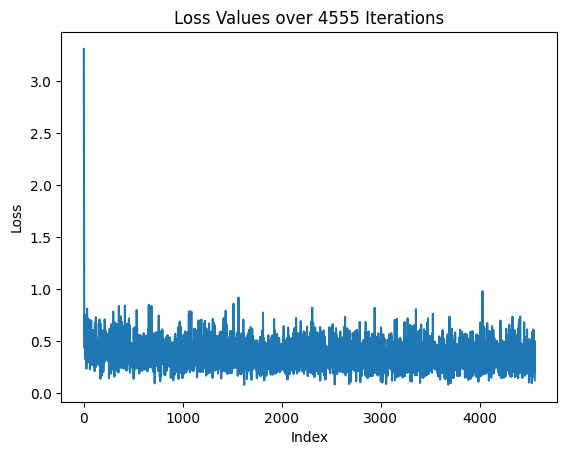

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 4555 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 98765 images including earlier ones) covering answer lengths from 12 to 17

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
T_ : 17, qn_tokens.shape : torch.Size([10, 21]), target_tokens:torch.Size([10, 17]), a:torch.Size([10, 17])
idx: 2979, loss: 0.7094388604164124 tgt-len: 17 Total_len : 94
T_ : 17, qn_tokens.shape : torch.Size([10, 16]), target_tokens:torch.Size([10, 17]), a:torch.Size([10, 17])
idx: 2980, loss: 0.5307528376579285 tgt-len: 17 Total_len : 89
T_ : 17, qn_tokens.shape : torch.Size([10, 14]), target_tokens:torch.Size([10, 17]), a:torch.Size([10, 17])
idx: 2981, loss: 0.8445558547973633 tgt-len: 17 Total_len : 87
T_ : 16, qn_tokens.shape : torch.Size([10, 13]), target_tokens:torch.Size([10, 16]), a:torch.Size([10, 16])
idx: 2982, loss: 0.7391152381896973 tgt-len: 16 Total_len : 85
T_ : 17, qn_tokens.shape : torch.Size([10, 15]), target_tokens:torch.Size([10, 17]), a:torch.Size([10, 17])
idx: 2983, loss: 0.878938615322113 tgt-len: 17 Total_len : 88
T_ : 17, qn_tokens.shape : torch.Size([10, 17]), target_tokens:torch.Size([10, 17]), a:torch.Si

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***phi2_proj_models saved at idx : {idx}')

***phi2_proj_models saved at idx : 5320


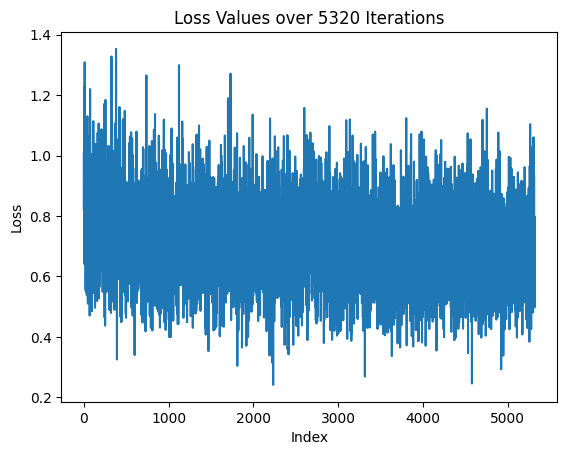

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 5320 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 143378 images including earlier ones) covering answer lengths from 18 to 23

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
T_ : 23, qn_tokens.shape : torch.Size([9, 18]), target_tokens:torch.Size([9, 23]), a:torch.Size([9, 23])
idx: 2616, loss: 0.8666349053382874 tgt-len: 23 Total_len : 97
T_ : 22, qn_tokens.shape : torch.Size([9, 19]), target_tokens:torch.Size([9, 22]), a:torch.Size([9, 22])
idx: 2617, loss: 0.8228518962860107 tgt-len: 22 Total_len : 97
T_ : 22, qn_tokens.shape : torch.Size([9, 17]), target_tokens:torch.Size([9, 22]), a:torch.Size([9, 22])
idx: 2618, loss: 0.9825021624565125 tgt-len: 22 Total_len : 95
T_ : 22, qn_tokens.shape : torch.Size([9, 17]), target_tokens:torch.Size([9, 22]), a:torch.Size([9, 22])
idx: 2619, loss: 0.9481146335601807 tgt-len: 22 Total_len : 95
T_ : 23, qn_tokens.shape : torch.Size([9, 17]), target_tokens:torch.Size([9, 23]), a:torch.Size([9, 23])
idx: 2620, loss: 0.8086100816726685 tgt-len: 23 Total_len : 96
T_ : 23, qn_tokens.shape : torch.Size([9, 17]), target_tokens:torch.Size([9, 23]), a:torch.Size([9, 23])
idx:

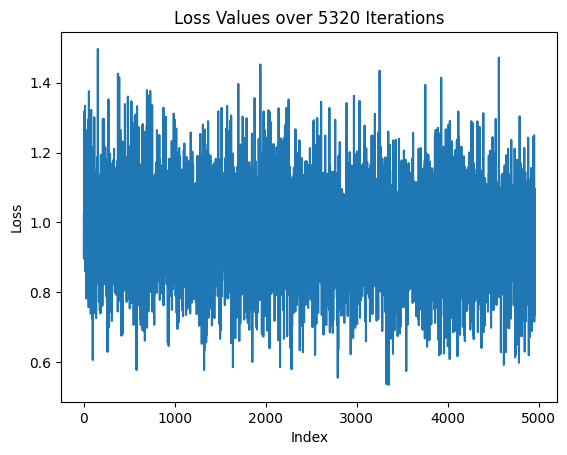

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 5320 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 195830 images including earlier ones) covering answer lengths from 24 to 40

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 4215, loss: 0.9736762642860413 tgt-len: 35 Total_len : 111
T_ : 38, qn_tokens.shape : torch.Size([8, 15]), target_tokens:torch.Size([8, 38]), a:torch.Size([8, 38])
idx: 4216, loss: 0.8751954436302185 tgt-len: 38 Total_len : 109
T_ : 40, qn_tokens.shape : torch.Size([8, 16]), target_tokens:torch.Size([8, 40]), a:torch.Size([8, 40])
idx: 4217, loss: 1.01642644405365 tgt-len: 40 Total_len : 112
T_ : 36, qn_tokens.shape : torch.Size([8, 16]), target_tokens:torch.Size([8, 36]), a:torch.Size([8, 36])
idx: 4218, loss: 1.1755295991897583 tgt-len: 36 Total_len : 108
T_ : 39, qn_tokens.shape : torch.Size([8, 17]), target_tokens:torch.Size([8, 39]), a:torch.Size([8, 39])
idx: 4219, loss: 0.88506019115448 tgt-len: 39 Total_len : 112
T_ : 39, qn_tokens.shape : torch.Size([8, 14]), target_tokens:torch.Size([8, 39]), a:torch.Size([8, 39])
idx: 4220, loss: 0.8591853976249695 tgt-len: 39 Total_len : 109
T_ : 35, qn_tokens.shape : torch.Size([8, 15

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 6555


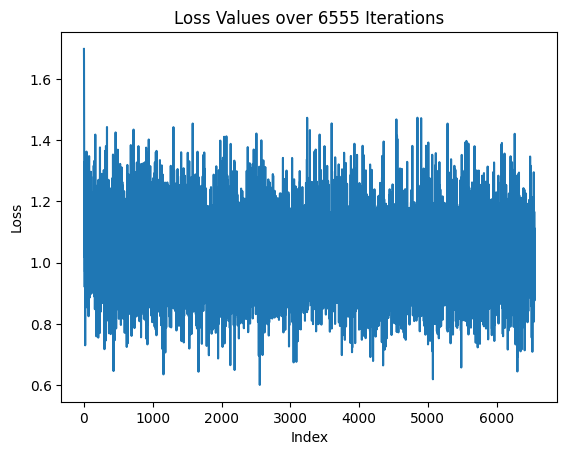

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 6555 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 209312 images including earlier ones) covering answer lengths from 41 to 59

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 53, qn_tokens.shape : torch.Size([6, 22]), target_tokens:torch.Size([6, 53]), a:torch.Size([6, 53])
idx: 0, loss: 1.5098201036453247 tgt-len: 53 Total_len : 131
T_ : 58, qn_tokens.shape : torch.Size([6, 13]), target_tokens:torch.Size([6, 58]), a:torch.Size([6, 58])
idx: 1, loss: 1.1224757432937622 tgt-len: 58 Total_len : 127
T_ : 57, qn_tokens.shape : torch.Size([6, 14]), target_tokens:torch.Size([6, 57]), a:torch.Size([6, 57])
idx: 2, loss: 1.5700256824493408 tgt-len: 57 Total_len : 127
T_ : 50, qn_tokens.shape : torch.Size([6, 12]), target_tokens:torch.Size([6, 50]), a:torch.Size([6, 50])
idx: 3, loss: 1.4779103994369507 tgt-len: 50 Total_len : 118
T_ : 55, qn_tokens.shape : torch.Size([6, 23]), target_tokens:torch.Size([6, 55]), a:torch.Size([6, 55])
idx: 4, loss: 1.2635949850082397 tgt-len: 55 Total_len : 134
T_ : 58, qn_tokens.shape : torch.Size([6, 13]), target_tokens:torch.Size([6, 58]), a:torch.Size([6, 58])
idx: 5, loss: 1.1983476877212524 tgt-len: 58 Total_len : 127
T_ :

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 2246


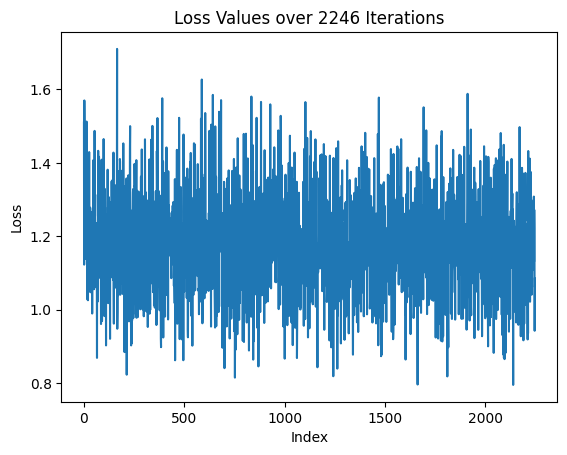

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 2246 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 217662 images including earlier ones) covering answer lengths from 60 to 79

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 78, qn_tokens.shape : torch.Size([5, 20]), target_tokens:torch.Size([5, 78]), a:torch.Size([5, 78])
idx: 0, loss: 1.4035786390304565 tgt-len: 78 Total_len : 154
T_ : 79, qn_tokens.shape : torch.Size([5, 18]), target_tokens:torch.Size([5, 79]), a:torch.Size([5, 79])
idx: 1, loss: 1.5650231838226318 tgt-len: 79 Total_len : 153
T_ : 78, qn_tokens.shape : torch.Size([5, 16]), target_tokens:torch.Size([5, 78]), a:torch.Size([5, 78])
idx: 2, loss: 1.133935809135437 tgt-len: 78 Total_len : 150
T_ : 79, qn_tokens.shape : torch.Size([5, 19]), target_tokens:torch.Size([5, 79]), a:torch.Size([5, 79])
idx: 3, loss: 1.4471163749694824 tgt-len: 79 Total_len : 154
T_ : 76, qn_tokens.shape : torch.Size([5, 20]), target_tokens:torch.Size([5, 76]), a:torch.Size([5, 76])
idx: 4, loss: 1.185736894607544 tgt-len: 76 Total_len : 152
T_ : 79, qn_tokens.shape : torch.Size([5, 17]), target_tokens:torch.Size([5, 79]), a:torch.Size([5, 79])
idx: 5, loss: 1.592814326286316 tgt-len: 79 Total_len : 152
T_ : 79

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 1668


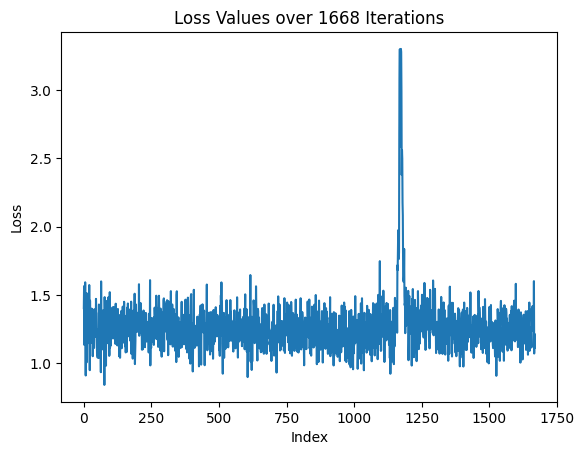

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 1668 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 233824 images including earlier ones) covering answer lengths from 80 to 99

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 1725, loss: 1.257583737373352 tgt-len: 95 Total_len : 173
T_ : 95, qn_tokens.shape : torch.Size([4, 19]), target_tokens:torch.Size([4, 95]), a:torch.Size([4, 95])
idx: 1726, loss: 1.2720235586166382 tgt-len: 95 Total_len : 170
T_ : 98, qn_tokens.shape : torch.Size([4, 20]), target_tokens:torch.Size([4, 98]), a:torch.Size([4, 98])
idx: 1727, loss: 1.1693017482757568 tgt-len: 98 Total_len : 174
T_ : 97, qn_tokens.shape : torch.Size([4, 27]), target_tokens:torch.Size([4, 97]), a:torch.Size([4, 97])
idx: 1728, loss: 1.2844113111495972 tgt-len: 97 Total_len : 180
T_ : 94, qn_tokens.shape : torch.Size([4, 21]), target_tokens:torch.Size([4, 94]), a:torch.Size([4, 94])
idx: 1729, loss: 1.4638612270355225 tgt-len: 94 Total_len : 171
T_ : 93, qn_tokens.shape : torch.Size([4, 14]), target_tokens:torch.Size([4, 93]), a:torch.Size([4, 93])
idx: 1730, loss: 1.4633811712265015 tgt-len: 93 Total_len : 163
T_ : 99, qn_tokens.shape : torch.Size([4,

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 4039


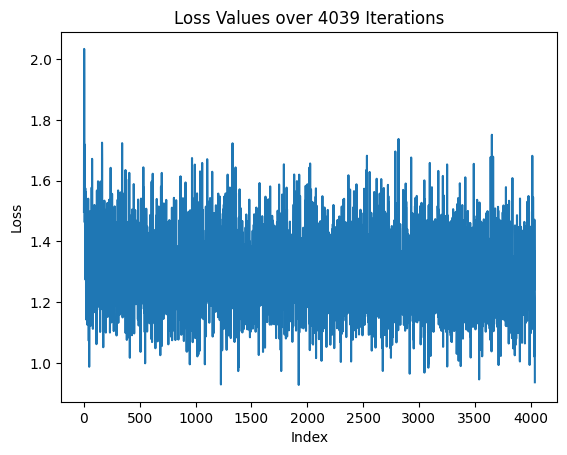

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 4039 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 262052 images including earlier ones) covering answer lengths from 100 to 119

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

Streaming output truncated to the last 5000 lines.
idx: 4780, loss: 1.5533156394958496 tgt-len: 113 Total_len : 192
T_ : 117, qn_tokens.shape : torch.Size([4, 20]), target_tokens:torch.Size([4, 117]), a:torch.Size([4, 117])
idx: 4781, loss: 1.226307988166809 tgt-len: 117 Total_len : 193
T_ : 117, qn_tokens.shape : torch.Size([4, 26]), target_tokens:torch.Size([4, 117]), a:torch.Size([4, 117])
idx: 4782, loss: 1.2085864543914795 tgt-len: 117 Total_len : 199
T_ : 118, qn_tokens.shape : torch.Size([4, 20]), target_tokens:torch.Size([4, 118]), a:torch.Size([4, 118])
idx: 4783, loss: 1.2916882038116455 tgt-len: 118 Total_len : 194
T_ : 118, qn_tokens.shape : torch.Size([4, 21]), target_tokens:torch.Size([4, 118]), a:torch.Size([4, 118])
idx: 4784, loss: 1.4639042615890503 tgt-len: 118 Total_len : 195
T_ : 119, qn_tokens.shape : torch.Size([4, 28]), target_tokens:torch.Size([4, 119]), a:torch.Size([4, 119])
idx: 4785, loss: 1.3717142343521118 tgt-len: 119 Total_len : 203
T_ : 117, qn_tokens.

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 7053


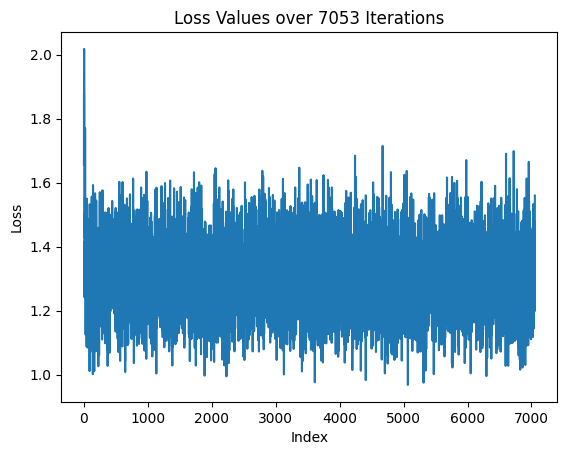

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 7053 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 321504 images including earlier ones) covering answer lengths from 120 to 200 - Discarded due to NaN error !

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 178, qn_tokens.shape : torch.Size([9, 21]), target_tokens:torch.Size([9, 178]), a:torch.Size([9, 178])


OutOfMemoryError: CUDA out of memory. Tried to allocate 46.00 MiB. GPU 0 has a total capacty of 39.56 GiB of which 6.81 MiB is free. Process 81550 has 39.55 GiB memory in use. Of the allocated memory 37.96 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 4138


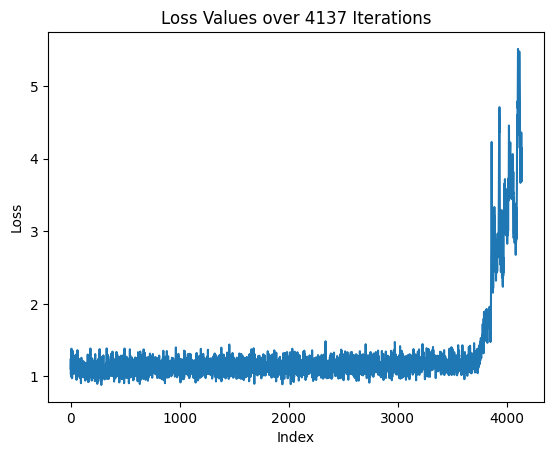

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 4137 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 280052 images including earlier ones) covering answer lengths from 120 to 200 !

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 131, qn_tokens.shape : torch.Size([9, 24]), target_tokens:torch.Size([9, 131]), a:torch.Size([9, 131])
idx: 0, loss: 1.338684320449829 tgt-len: 131 Total_len : 211
T_ : 131, qn_tokens.shape : torch.Size([9, 26]), target_tokens:torch.Size([9, 131]), a:torch.Size([9, 131])
idx: 1, loss: 1.3756554126739502 tgt-len: 131 Total_len : 213
T_ : 131, qn_tokens.shape : torch.Size([9, 23]), target_tokens:torch.Size([9, 131]), a:torch.Size([9, 131])
idx: 2, loss: 1.3364472389221191 tgt-len: 131 Total_len : 210
T_ : 131, qn_tokens.shape : torch.Size([9, 20]), target_tokens:torch.Size([9, 131]), a:torch.Size([9, 131])
idx: 3, loss: 1.3154808282852173 tgt-len: 131 Total_len : 207
T_ : 130, qn_tokens.shape : torch.Size([9, 23]), target_tokens:torch.Size([9, 130]), a:torch.Size([9, 130])
idx: 4, loss: 1.3613888025283813 tgt-len: 130 Total_len : 209
T_ : 130, qn_tokens.shape : torch.Size([9, 18]), target_tokens:torch.Size([9, 130]), a:torch.Size([9, 130])
idx: 5, loss: 1.3785488605499268 tgt-len: 1

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 1999


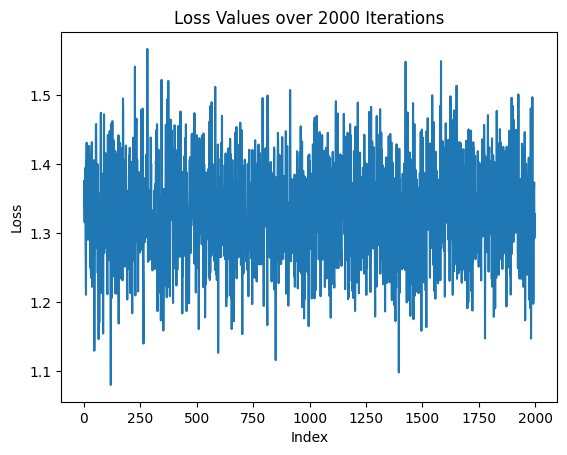

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 2000 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 298052 images including earlier ones) covering answer lengths from 120 to 200 !

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 141, qn_tokens.shape : torch.Size([9, 25]), target_tokens:torch.Size([9, 141]), a:torch.Size([9, 141])
idx: 0, loss: 1.2890434265136719 tgt-len: 141 Total_len : 222
T_ : 146, qn_tokens.shape : torch.Size([9, 29]), target_tokens:torch.Size([9, 146]), a:torch.Size([9, 146])
idx: 1, loss: 1.3241698741912842 tgt-len: 146 Total_len : 231
T_ : 145, qn_tokens.shape : torch.Size([9, 20]), target_tokens:torch.Size([9, 145]), a:torch.Size([9, 145])
idx: 2, loss: 1.242536187171936 tgt-len: 145 Total_len : 221
T_ : 145, qn_tokens.shape : torch.Size([9, 17]), target_tokens:torch.Size([9, 145]), a:torch.Size([9, 145])
idx: 3, loss: 1.3600353002548218 tgt-len: 145 Total_len : 218
T_ : 147, qn_tokens.shape : torch.Size([9, 27]), target_tokens:torch.Size([9, 147]), a:torch.Size([9, 147])
idx: 4, loss: 1.3696362972259521 tgt-len: 147 Total_len : 230
T_ : 146, qn_tokens.shape : torch.Size([9, 27]), target_tokens:torch.Size([9, 146]), a:torch.Size([9, 146])
idx: 5, loss: 1.2744407653808594 tgt-len: 1

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 1999


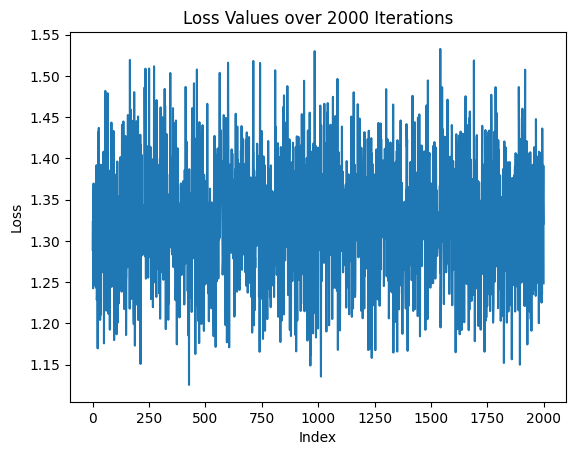

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 2000 Iterations")

# Show the plot
plt.show()

##### Training Loop (now covered 316052 images including earlier ones) covering answer lengths from 120 to 200 ! - Discarded due to NaN error !

In [ ]:
loss_lst = []

for idx, batch in enumerate(dataloader):
    torch.set_grad_enabled(True)
    pil_img_lst = []
    for img_name_b in batch['image_names']:
        image_name = img_name_b.split('_')[0]
        image = Image.open(f"/content/instruct150K/{image_name}")
        pil_img_lst.append(image)

    qn_tokens = batch['qn'].to(device)
    ans_tokens = batch['ans'].to(device)
    target_tokens = batch['ans'].to(device)
    T_ = target_tokens.shape[-1]  # B, Length of largest answer in batch
    Q_ = qn_tokens.shape[-1] # B, Length of largest qn in batch
    print(f'T_ : {T_}, qn_tokens.shape : {qn_tokens.shape}, target_tokens:{target_tokens.shape}, a:{ans_tokens.shape}')
    # if T_ < 17:

    output, input_embed, inputs_given = phi2_proj_model(pil_img_lst, qn_tokens, target_tokens)  # (B, target_len, 50297)
    # print(f'input_embed.shape : {input_embed.shape} output.logits.shape : {output.logits.shape}, inputs_given.shape :{inputs_given.shape}')
    ans_pos = 49 + 4 + Q_ + 3
    # print(f'T_ : {T_+1} == {input_embed.shape[1]-ans_pos}')
    pred_logits = output.logits[:,ans_pos:, :]
    # print(f'pred_logits.shape : {pred_logits.shape}')

    B, T, C = pred_logits.shape  # (B, target_len, 50297)
    pred_logits = pred_logits.reshape(B*T, C)  # B*T, 50297

    preds = F.softmax(pred_logits, dim=-1).to(torch.float32) # B*T, 50297
    top_prob = torch.multinomial(preds, num_samples=1) # B*T, 1
    display_ids = top_prob.view(B, T)   # B, T

    eos_tensor = torch.full((B, 1), eos_token_id, dtype=torch.int64).to(device)  # B, 1 -> EOS token matrix
    targets = torch.cat((target_tokens, eos_tensor), dim=1)  # B, T_+1 -> Adding EOS token at end of each batch
    # targets = targets[:, 1:]  # Offset by one position
    tgts = targets.reshape(B * (T_+1)) # B*T_-> Reshaping for loss fn

    # print(f'pred_logits.shape : {pred_logits.shape} tgts.shape : {tgts.shape}')
    loss = F.cross_entropy(pred_logits, tgts)
    # loss.requires_grad = True
    loss.backward()
    loss_lst.append(round(loss.item(),4))
    optimizer.step()
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    print(f'idx: {idx}, loss: {loss} tgt-len: {T_} Total_len : {ans_pos+T_}')

    # else:
    #     print(f'idx: {idx} Caption too long ! Hence skipping - img_name_b : {img_name_b}, T_: {T_}')

    if idx % 50 == 0 and idx > 0:
        out_text = tokenizer.batch_decode(display_ids)
        in_text = tokenizer.batch_decode(inputs_given)
        print(f'idx : {idx}')
        print(f"inp: {in_text[0]}")
        print(f"pred: {out_text[0]}")
        print(f'tgt: {tokenizer.batch_decode(targets)[0]}')
        print(f"GT-QN: {tokenizer.decode(batch['qn'][0])}")
        print(f"GT-ANS: {tokenizer.decode(batch['ans'][0])}")

    if idx % 200 == 0 and idx > 0:
        torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
        torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
        torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
        print(f'***phi2_proj_models saved at idx : {idx}')

T_ : 171, qn_tokens.shape : torch.Size([9, 26]), target_tokens:torch.Size([9, 171]), a:torch.Size([9, 171])
idx: 0, loss: 1.3940893411636353 tgt-len: 171 Total_len : 253
T_ : 179, qn_tokens.shape : torch.Size([9, 21]), target_tokens:torch.Size([9, 179]), a:torch.Size([9, 179])
idx: 1, loss: 1.2684575319290161 tgt-len: 179 Total_len : 256
T_ : 180, qn_tokens.shape : torch.Size([9, 24]), target_tokens:torch.Size([9, 180]), a:torch.Size([9, 180])
idx: 2, loss: 1.3123923540115356 tgt-len: 180 Total_len : 260
T_ : 174, qn_tokens.shape : torch.Size([9, 21]), target_tokens:torch.Size([9, 174]), a:torch.Size([9, 174])
idx: 3, loss: 1.3757336139678955 tgt-len: 174 Total_len : 251
T_ : 175, qn_tokens.shape : torch.Size([9, 25]), target_tokens:torch.Size([9, 175]), a:torch.Size([9, 175])
idx: 4, loss: 1.1398680210113525 tgt-len: 175 Total_len : 256
T_ : 179, qn_tokens.shape : torch.Size([9, 21]), target_tokens:torch.Size([9, 179]), a:torch.Size([9, 179])
idx: 5, loss: 1.2153466939926147 tgt-len: 

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [ ]:
torch.save(phi2_proj_model.proj_lin_layer.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_ll.pth')
torch.save(phi2_proj_model.proj_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_projmodel.pth')
torch.save(phi2_proj_model.phi2_model.state_dict(), '/content/gdrive/MyDrive/ERA1/capstone/phi2_proj_model_offset_phi2.pth')
print(f'***Finished - phi2_proj_models saved at idx : {idx}')

***Finished - phi2_proj_models saved at idx : 1999


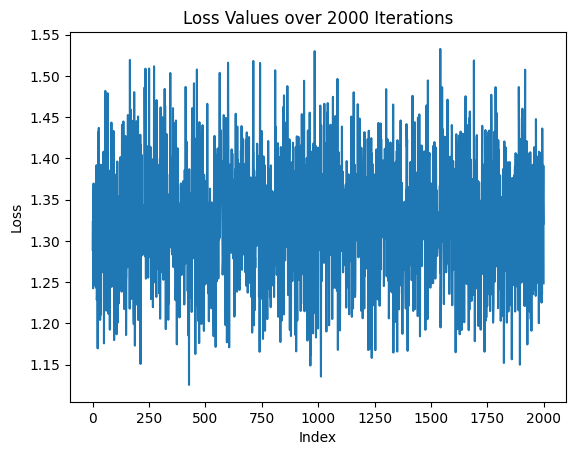

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.plot(range(len(loss_lst)), loss_lst)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Loss")
plt.title("Loss Values over 2000 Iterations")

# Show the plot
plt.show()

##### Moving model to HF

In [ ]:
grad_wt_count = 0
non_grad_wt_count = 0
for name, param in peft_phi2_model.named_parameters():
    if param.requires_grad:
        grad_wt_count += 1
        if name == "base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight":
            print(name, param)
        elif name == "base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight":
            print(name, param)
    else:
        non_grad_wt_count += 1
print(f'Parms with grad : {grad_wt_count} & Parms w/o grad : {non_grad_wt_count}')

base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight Parameter containing:
tensor([[ 0.0316,  0.0162,  0.0041,  ..., -0.0015, -0.0137, -0.0461],
        [ 0.0082,  0.0054, -0.0202,  ...,  0.0062, -0.0358, -0.0472],
        [ 0.0122, -0.0020,  0.0237,  ...,  0.0096, -0.0053, -0.0367],
        ...,
        [-0.0100,  0.0155,  0.0017,  ...,  0.0161, -0.0318, -0.0131],
        [ 0.0234, -0.0365, -0.0014,  ..., -0.0065, -0.0075, -0.0284],
        [-0.0192,  0.0239,  0.0123,  ..., -0.0051,  0.0306,  0.0409]],
       device='cuda:0', requires_grad=True)
base_model.model.model.layers.31.mlp.fc2.lora_B.default.weight Parameter containing:
tensor([[-0.0193,  0.0341,  0.0070,  ...,  0.0043,  0.0141, -0.0086],
        [-0.0143, -0.0030,  0.0578,  ...,  0.0069, -0.0024,  0.0200],
        [ 0.0104,  0.0007, -0.0141,  ...,  0.0303,  0.0096, -0.0346],
        ...,
        [-0.0034, -0.0220,  0.0259,  ...,  0.0344, -0.0198, -0.0041],
        [ 0.0020,  0.0062, -0.0195,  ...,  0.0154, 

In [ ]:
user = "anilbhatt1"  # put your user name here
model_name = "phi2-proj-offset-peft-model_ans120plus"
model_id = f"{user}/{model_name}"

In [ ]:
peft_phi2_model.push_to_hub(model_id)  # JAn 29 1:564 pm  (covered 298052 images answer lengths from 120 to 200)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/893M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anilbhatt1/phi2-proj-offset-peft-model_ans120plus/commit/9599c5802a6b14cbb6d833698a41957f8d40147a', commit_message='Upload model', commit_description='', oid='9599c5802a6b14cbb6d833698a41957f8d40147a', pr_url=None, pr_revision=None, pr_num=None)